## 1. Obtención de los datos

En esta sección, se carga los datos desde la base de datos y se va a convertir la serie temporal de ventas en un ejercicio Supervisado.

### 1.1 Cargar los datos desde la base de datos

Para la conexión con la base de datos se usa las librerías de `pandas` para mejorar los datos y `sqlalchemy` para la conexión con al base de datos.

In [ ]:
import pandas as pd
import sqlalchemy as sa


class DatabaseConnection:

    def __init__(
        self,
        username: str,
        password: str,
        database: str = "##",
        host: str = "##",
        port: int = ##,
        dialect: str = "mysql",
        driver: str = "pymysql",
    ) -> None:
        """Creates a connection to a database

        Args:
            username (str): username
            password (str): password
            dialect (str, optional): dialect. Defaults to "mysql".
            driver (str, optional): driver. Defaults to "pymysql".
            host (str, optional): host. Defaults to "##".
            port (int, optional): port. Defaults to ##.
            database (str, optional): database. Defaults to "data".
        """
        connection_string = f"{dialect}+{driver}://{username}:{password}@{host}:{port}/{database}"
        self.engine = sa.create_engine(connection_string)

    def insert_dataframe(self, df: pd.DataFrame, table_name: str) -> None:
        """Inserts a dataframe into a table
        
        Args:
            df (pd.DataFrame): dataframe to insert
            table_name (str): table name
        """
        df.to_sql(table_name, self.engine, if_exists="replace", index=False)

    def query_to_df(self, query: str) -> pd.DataFrame:
        """Retrieves a dataframe from a query.

        Args:
            query (str): query to perform.

        Returns:
            pd.DataFrame: daframe with the results of the query.
        """
        with self.engine.connect() as conn:
            df = pd.read_sql_query(query, conn)
            return df

    def check_connection(self) -> bool:
        """Checks if the connection is working

        Returns:
            bool: True if the connection is working, False otherwise
        """
        try:
            self.engine.connect()
        except Exception as e:
            print(e)
            return False

In [ ]:
DB_USERNAME = "###"
DB_PASSWORD = "####"
LOCATION = (###, ###)

Conexión con la base de datos

In [9]:
database = DatabaseConnection(DB_USERNAME, DB_PASSWORD)
database.check_connection()

Se realiza una consulta SQL para obtener los datos y se comprueba que funciona correctamente con un .info

In [10]:
query = """
    SELECT familia,
        articulo,
        fechaVenta AS fecha_venta,
        festivo,
        precio,
        cantidad,
        importe,
        orden_articulo_familia

    FROM jpra_ventas_diarias_estudio_completo
"""

df = database.query_to_df(query)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10574 entries, 0 to 10573
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   familia                 10574 non-null  object 
 1   articulo                10574 non-null  object 
 2   fecha_venta             10574 non-null  object 
 3   festivo                 837 non-null    object 
 4   precio                  10574 non-null  float64
 5   cantidad                10574 non-null  float64
 6   importe                 10574 non-null  float64
 7   orden_articulo_familia  10574 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 661.0+ KB


Se muestra los primeros valores.

In [11]:
df.head()

familia articulo fecha_venta festivo  precio  cantidad     importe  \
0  BOLLERIA     3880  2021-05-01    None   2.591   285.000  738.434998   
1  BOLLERIA     3960  2021-05-01    None   2.318   402.000  931.835995   
2  BOLLERIA     5803  2021-05-01    None   2.727   237.000  646.298981   
3  BOLLERIA     6286  2021-05-01    None   3.136   165.000  517.440006   
4  BOLLERIA     6425  2021-05-01    None  31.364    31.725  995.022083   

   orden_articulo_familia  
0                       3  
1                       1  
2                       5  
3                       4  
4                       2

Convertimos las fechas a formato datetime y los artículos a tipo int.

In [12]:
df["fecha_venta"] = pd.to_datetime(df["fecha_venta"])
df["articulo"] = df["articulo"].astype(int)

Se organiza los datos por fecha y se reinicia el índice.

In [13]:
df.sort_values(["fecha_venta"], inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

familia  articulo fecha_venta festivo  precio  cantidad     importe  \
0    BOLLERIA      3880  2021-05-01    None   2.591     285.0  738.434998   
1   PANADERIA       417  2021-05-01    None   4.038      72.0  290.736004   
2   PANADERIA      1084  2021-05-01    None   0.865     423.0  365.895005   
3   PANADERIA      1043  2021-05-01    None   2.596     327.0  848.892002   
4  PASTELERIA      5403  2021-05-01    None  34.091       3.0  102.273003   

   orden_articulo_familia  
0                       3  
1                       5  
2                       4  
3                       2  
4                       2

Nota: Todo lo relacionado al EDA está en el notebook [EDA](./DataScience-Project/Datathon_Bakery/2.%20EDA.ipynb)

### 1.2 Convertir la serie en formato supervisado

Para predecir las ventas, se necesita transformar los datos a un problema supervisado, para ello:    
- Se deberá obtener la `cantidad` contabilizada de los días anteriores y añadirlos al día presente.
- Se deberá obtener `cantidad` contabilizada de las semanas anteriores y añadirlos al día presente.

Se diseña una función que permite transformar la serie a formato supervisado.
La función recibe como parámetros el dataframe, número de días y semanas a considerar. 

In [14]:
def multi_product_series_to_supervised(
    df: pd.DataFrame,
    target_column: str = "cantidad",
    id_column: str = "articulo",
    daily_lag: int = 1,
    weekly_lag: int = 1,
) -> pd.DataFrame:
    """
    Converts multiple time series (grouped by product) into a supervised learning dataset.
    
    Args:
        df: Input DataFrame with columns: fecha_venta, articulo, cantidad, etc.
        target_column: Name of the target variable column (default: "cantidad").
        id_column: Name of the column identifying products (default: "articulo").
        daily_lag: Number of daily lags to include (default: 1).
        weekly_lag: Number of weekly lags to include (default: 1).
    
    Returns:
        DataFrame with lagged features for each product.
    """
    # Verificar que la columna de fecha existe
    if 'fecha_venta' not in df.columns:
        raise ValueError("El DataFrame debe contener una columna 'fecha_venta'.")

    resultados = []
    
    # Ordenar por artículo y fecha
    df = df.sort_values([id_column, 'fecha_venta'])
    
    for articulo in df[id_column].unique():
        # Filtrar datos para el artículo actual
        df_articulo = df[df[id_column] == articulo].copy()
        
        # Crear características de lag para este artículo
        target_feature = df_articulo[target_column]
        
        # Función interna para crear lags
        def create_shifted_feature(lag: int, frequency: int, freq_label: str):
            shifted_feature = target_feature.shift(lag * frequency)
            feature_name = f"{target_column}_lag_{lag}_{freq_label}"
            df_articulo[feature_name] = shifted_feature
        
        # Añadir lags semanales (t-7, t-14, ...)
        for lag in range(1, weekly_lag + 1):
            create_shifted_feature(lag, 7, "weeks")
        
        # Añadir lags diarios (t-1, t-2, ...)
        for lag in range(1, daily_lag + 1):
            create_shifted_feature(lag, 1, "days")
        
        resultados.append(df_articulo)
    
    # Combinar todos los DataFrames y resetear índice
    return pd.concat(resultados).reset_index(drop=True)

In [15]:
df_supervised = multi_product_series_to_supervised(
    df=df,  # <- Aquí usas tu DataFrame real
    target_column="cantidad",
    id_column="articulo",
    daily_lag=6,  # Lags diarios: t-1, t-2, ..., t-6
    weekly_lag=4   # Lags semanales: t-7, t-14, t-21, t-28
)
df_supervised.head()

familia  articulo fecha_venta          festivo  precio  cantidad  \
0  PANADERIA       417  2021-05-01             None   4.038      72.0   
1  PANADERIA       417  2021-05-02  Día de la Madre   4.038      81.0   
2  PANADERIA       417  2021-05-03   Día de la Cruz   4.038      90.0   
3  PANADERIA       417  2021-05-04             None   4.038      84.0   
4  PANADERIA       417  2021-05-05             None   4.038      84.0   

      importe  orden_articulo_familia  cantidad_lag_1_weeks  \
0  290.736004                       5                   NaN   
1  327.077995                       5                   NaN   
2  363.419998                       5                   NaN   
3  339.192001                       5                   NaN   
4  339.192003                       5                   NaN   

   cantidad_lag_2_weeks  cantidad_lag_3_weeks  cantidad_lag_4_weeks  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   

   cantidad_lag_1_days  cantidad_lag_2_days  cantidad_lag_3_days  \
0                  NaN                  NaN                  NaN   
1                 72.0                  NaN                  NaN   
2                 81.0                 72.0                  NaN   
3                 90.0                 81.0                 72.0   
4                 84.0                 90.0                 81.0   

   cantidad_lag_4_days  cantidad_lag_5_days  cantidad_lag_6_days  
0                  NaN                  NaN                  NaN  
1                  NaN                  NaN                  NaN  
2                  NaN                  NaN                  NaN  
3                  NaN                  NaN                  NaN  
4                 72.0                  NaN                  NaN

In [16]:
df_supervised.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10574 entries, 0 to 10573
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   familia                 10574 non-null  object        
 1   articulo                10574 non-null  int64         
 2   fecha_venta             10574 non-null  datetime64[ns]
 3   festivo                 837 non-null    object        
 4   precio                  10574 non-null  float64       
 5   cantidad                10574 non-null  float64       
 6   importe                 10574 non-null  float64       
 7   orden_articulo_familia  10574 non-null  int64         
 8   cantidad_lag_1_weeks    10469 non-null  float64       
 9   cantidad_lag_2_weeks    10364 non-null  float64       
 10  cantidad_lag_3_weeks    10259 non-null  float64       
 11  cantidad_lag_4_weeks    10154 non-null  float64       
 12  cantidad_lag_1_days     10559 non-null  float6

## 2. Procesamiento de los datos

En este paso se creará un Flujo de Transformación de Datos (Data Pipeline).

### 2.1 Extraer info de la fecha de venta

Con este campo se va a crear las siguientes columnas:

- dayofweek: Día de la semana.
- day: Día del mes.
- month: El mes.
- year: El año.
- weekend: Si es fin de semana.

Se va a crear la siguiente función para extraer los nuevos campos y adicionarlos al df.

In [17]:
def add_date_columns(df: pd.DataFrame, date_column: str = "fecha_venta") -> pd.DataFrame:
    df["day"] = df[date_column].dt.day
    df["month"] = df[date_column].dt.month
    df["year"] = df[date_column].dt.year
    df["dayofweek"] = df[date_column].dt.dayofweek + 1
    df["isWeekend"] = df["dayofweek"] >= 6
    return df

df_supervised_tmp = add_date_columns(df_supervised.copy())
df_supervised_tmp.head()

familia  articulo fecha_venta          festivo  precio  cantidad  \
0  PANADERIA       417  2021-05-01             None   4.038      72.0   
1  PANADERIA       417  2021-05-02  Día de la Madre   4.038      81.0   
2  PANADERIA       417  2021-05-03   Día de la Cruz   4.038      90.0   
3  PANADERIA       417  2021-05-04             None   4.038      84.0   
4  PANADERIA       417  2021-05-05             None   4.038      84.0   

      importe  orden_articulo_familia  cantidad_lag_1_weeks  \
0  290.736004                       5                   NaN   
1  327.077995                       5                   NaN   
2  363.419998                       5                   NaN   
3  339.192001                       5                   NaN   
4  339.192003                       5                   NaN   

   cantidad_lag_2_weeks  ...  cantidad_lag_2_days  cantidad_lag_3_days  \
0                   NaN  ...                  NaN                  NaN   
1                   NaN  ...                  NaN                  NaN   
2                   NaN  ...                 72.0                  NaN   
3                   NaN  ...                 81.0                 72.0   
4                   NaN  ...                 90.0                 81.0   

   cantidad_lag_4_days  cantidad_lag_5_days  cantidad_lag_6_days  day  month  \
0                  NaN                  NaN                  NaN    1      5   
1                  NaN                  NaN                  NaN    2      5   
2                  NaN                  NaN                  NaN    3      5   
3                  NaN                  NaN                  NaN    4      5   
4                 72.0                  NaN                  NaN    5      5   

   year  dayofweek  isWeekend  
0  2021          6       True  
1  2021          7       True  
2  2021          1      False  
3  2021          2      False  
4  2021          3      False  

[5 rows x 23 columns]

### 2.2 Agregar columnas adicionales

Se agrega las siguientes columnas:

- `isHoliday`: Indica con un True y False si es un día festivo o no.
- `isBridgeDay`: Solo aplica para días que son puentes cuando el festivo es un jueves, el valor se marcará True un viernes y si el festivo es martes, el lunes se marcará como True.
- `preHoliday`: Indica True si el día es un día anterior a un festivo.
- `postHoliday`: Indica True si hay un festivo el día anterior.

Además la función elimina la columna de `festivo` porque ya se está usando la columna `isHoliday`


In [18]:
from datetime import timedelta
import pandas as pd

def add_holiday_features(
    df: pd.DataFrame,
    date_column: str = "fecha_venta",
    raw_holiday_column: str = "festivo",
    holiday_column: str = "isHoliday"
) -> pd.DataFrame:
    """
    Añade columna booleana de festivo (`isHoliday`) y contexto:
    - isBridgeDay: Viernes si el festivo es jueves, o lunes si es martes.
    - preHoliday: Día anterior a un festivo.
    - postHoliday: Día posterior a un festivo.
    """
    df = df.copy()

    # Convertir fechas si es necesario
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')

    # Crear columna isHoliday desde la columna original de festivos
    if raw_holiday_column in df.columns:
        df[holiday_column] = ~df[raw_holiday_column].isna()
        df.drop(columns=[raw_holiday_column], inplace=True)
    else:
        print(f"Advertencia: Columna '{raw_holiday_column}' no encontrada. No se marcarán festivos.")
        df[holiday_column] = False

    # Inicializar columnas de contexto
    df["isBridgeDay"] = False
    df["preHoliday"] = False
    df["postHoliday"] = False

    # Identificar fechas festivas
    holiday_dates = df.loc[df[holiday_column], date_column].dropna().unique()

    for holiday in holiday_dates:
        try:
            holiday = pd.to_datetime(holiday)

            pre_day = holiday - timedelta(days=1)
            post_day = holiday + timedelta(days=1)

            df.loc[df[date_column] == pre_day, "preHoliday"] = True
            df.loc[df[date_column] == post_day, "postHoliday"] = True

            if holiday.weekday() == 3:  # Jueves -> puente viernes
                df.loc[df[date_column] == (holiday + timedelta(days=1)), "isBridgeDay"] = True
            elif holiday.weekday() == 1:  # Martes -> puente lunes
                df.loc[df[date_column] == (holiday - timedelta(days=1)), "isBridgeDay"] = True

        except Exception as e:
            print(f"Error procesando fecha {holiday}: {str(e)}")

    return df


df_supervised_tmp = add_holiday_features(df_supervised.copy())
df_supervised_tmp.head()

familia  articulo fecha_venta  precio  cantidad     importe  \
0  PANADERIA       417  2021-05-01   4.038      72.0  290.736004   
1  PANADERIA       417  2021-05-02   4.038      81.0  327.077995   
2  PANADERIA       417  2021-05-03   4.038      90.0  363.419998   
3  PANADERIA       417  2021-05-04   4.038      84.0  339.192001   
4  PANADERIA       417  2021-05-05   4.038      84.0  339.192003   

   orden_articulo_familia  cantidad_lag_1_weeks  cantidad_lag_2_weeks  \
0                       5                   NaN                   NaN   
1                       5                   NaN                   NaN   
2                       5                   NaN                   NaN   
3                       5                   NaN                   NaN   
4                       5                   NaN                   NaN   

   cantidad_lag_3_weeks  ...  cantidad_lag_1_days  cantidad_lag_2_days  \
0                   NaN  ...                  NaN                  NaN   
1                   NaN  ...                 72.0                  NaN   
2                   NaN  ...                 81.0                 72.0   
3                   NaN  ...                 90.0                 81.0   
4                   NaN  ...                 84.0                 90.0   

   cantidad_lag_3_days  cantidad_lag_4_days  cantidad_lag_5_days  \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   
2                  NaN                  NaN                  NaN   
3                 72.0                  NaN                  NaN   
4                 81.0                 72.0                  NaN   

   cantidad_lag_6_days  isHoliday  isBridgeDay  preHoliday  postHoliday  
0                  NaN      False        False        True        False  
1                  NaN       True        False        True        False  
2                  NaN       True        False       False         True  
3                  NaN      False        False       False         True  
4                  NaN      False        False       False        False  

[5 rows x 21 columns]

### 2.3 Se agrega Información meteorológica


Se utiliza la API de meteostat para obtener los datos meteorológicos.
Se añadirá la columna `isRaining` para indicar si ese día hubo lluvia o no. Los valores serán verdader o falso.

In [19]:
from datetime import datetime
from meteostat import Point, Daily
import numpy as np


def get_weather_df(start: datetime, end: datetime, location: tuple[int, int]) -> pd.DataFrame:
    lat, lon = location
    point = Point(lat, lon)
    return Daily(point, start, end).fetch().fillna(0).reset_index()

def merge_dfs_by_column(df1: pd.DataFrame, df2: pd.DataFrame, col_1_name: str, col_2_name: str) -> pd.DataFrame:
    merged_df = df1.reset_index().merge(df2, left_on=col_1_name, right_on=col_2_name, how="inner").set_index("index")
    merged_df.index.name = None
    return merged_df

def add_rain_column(df: pd.DataFrame, precipitation_column_name: str = "prcp") -> pd.DataFrame:
    rain_condition = df[precipitation_column_name] > 0
    df["isRaining"] = np.where(rain_condition, True, False)
    return df

def add_weather_columns(
    df: pd.DataFrame,
    location: tuple[int, int],
    date_column_name: str = "fecha_venta",
) -> pd.DataFrame:
    start = df[date_column_name].min()
    end = df[date_column_name].max()
    weather_df = get_weather_df(start, end, location)
    weather_df = add_rain_column(weather_df)
    weather_df = merge_dfs_by_column(df, weather_df, date_column_name, "time")
    return weather_df


df_supervised_tmp = df_supervised.copy()
add_weather_columns(df_supervised, LOCATION).head()


familia  articulo fecha_venta          festivo  precio  cantidad  \
0  PANADERIA       417  2021-05-01             None   4.038      72.0   
1  PANADERIA       417  2021-05-02  Día de la Madre   4.038      81.0   
2  PANADERIA       417  2021-05-03   Día de la Cruz   4.038      90.0   
3  PANADERIA       417  2021-05-04             None   4.038      84.0   
4  PANADERIA       417  2021-05-05             None   4.038      84.0   

      importe  orden_articulo_familia  cantidad_lag_1_weeks  \
0  290.736004                       5                   NaN   
1  327.077995                       5                   NaN   
2  363.419998                       5                   NaN   
3  339.192001                       5                   NaN   
4  339.192003                       5                   NaN   

   cantidad_lag_2_weeks  ...  tmin  tmax  prcp  snow  wdir  wspd  wpgt  \
0                   NaN  ...  11.9  22.8   0.0   0.0   0.0  14.2   0.0   
1                   NaN  ...  10.8  23.2   0.0   0.0   0.0  15.7   0.0   
2                   NaN  ...  12.7  20.1   6.5   0.0   0.0   9.7   0.0   
3                   NaN  ...  12.0  20.9   0.0   0.0   0.0  12.1   0.0   
4                   NaN  ...  12.3  21.7   0.0   0.0   0.0  13.8   0.0   

     pres tsun  isRaining  
0  1014.0  0.0      False  
1  1015.9  0.0      False  
2  1017.7  0.0       True  
3  1018.0  0.0      False  
4  1016.5  0.0      False  

[5 rows x 30 columns]

In [20]:
# Crear una copia indepediente del DataFrame originnal
df_final = df_supervised.copy()

# Aplicar las funciones en secuencia
df_final = add_date_columns(df_final)
df_final = add_holiday_features(df_final)
df_final = add_weather_columns(df_final, LOCATION)

df_final.head()


familia  articulo fecha_venta  precio  cantidad     importe  \
0  PANADERIA       417  2021-05-01   4.038      72.0  290.736004   
1  PANADERIA       417  2021-05-02   4.038      81.0  327.077995   
2  PANADERIA       417  2021-05-03   4.038      90.0  363.419998   
3  PANADERIA       417  2021-05-04   4.038      84.0  339.192001   
4  PANADERIA       417  2021-05-05   4.038      84.0  339.192003   

   orden_articulo_familia  cantidad_lag_1_weeks  cantidad_lag_2_weeks  \
0                       5                   NaN                   NaN   
1                       5                   NaN                   NaN   
2                       5                   NaN                   NaN   
3                       5                   NaN                   NaN   
4                       5                   NaN                   NaN   

   cantidad_lag_3_weeks  ...  tmin  tmax  prcp  snow  wdir  wspd  wpgt  \
0                   NaN  ...  11.9  22.8   0.0   0.0   0.0  14.2   0.0   
1                   NaN  ...  10.8  23.2   0.0   0.0   0.0  15.7   0.0   
2                   NaN  ...  12.7  20.1   6.5   0.0   0.0   9.7   0.0   
3                   NaN  ...  12.0  20.9   0.0   0.0   0.0  12.1   0.0   
4                   NaN  ...  12.3  21.7   0.0   0.0   0.0  13.8   0.0   

     pres  tsun  isRaining  
0  1014.0   0.0      False  
1  1015.9   0.0      False  
2  1017.7   0.0       True  
3  1018.0   0.0      False  
4  1016.5   0.0      False  

[5 rows x 38 columns]

## 3. Creación de Pipeline

### 3.1 Preprocesamiento de los datos de entrada

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin


class PreprocessTransformer(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self, location: tuple[int, int], daily_lag: int, weekly_lag: int):
        self.location = location
        self.daily_lag = daily_lag
        self.weekly_lag = weekly_lag

    def fit(self, X: pd.DataFrame, y: pd.Series | None = None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()  # avoid modifying incoming data
        X = add_date_columns(X)
        X = add_holiday_features(X)
        X = add_weather_columns(X, location=self.location)
        return X

In [22]:
preprocessor = PreprocessTransformer(location=LOCATION, daily_lag=6, weekly_lag=4)
preprocessed_df = preprocessor.transform(df_supervised)
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10574 entries, 0 to 10573
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   familia                 10574 non-null  object        
 1   articulo                10574 non-null  int64         
 2   fecha_venta             10574 non-null  datetime64[ns]
 3   precio                  10574 non-null  float64       
 4   cantidad                10574 non-null  float64       
 5   importe                 10574 non-null  float64       
 6   orden_articulo_familia  10574 non-null  int64         
 7   cantidad_lag_1_weeks    10469 non-null  float64       
 8   cantidad_lag_2_weeks    10364 non-null  float64       
 9   cantidad_lag_3_weeks    10259 non-null  float64       
 10  cantidad_lag_4_weeks    10154 non-null  float64       
 11  cantidad_lag_1_days     10559 non-null  float64       
 12  cantidad_lag_2_days     10544 non-null  float64    

### 3.2 Normalización de los datos de entrada

Antes de hacer indicar los valores, se eliminaran las siguientes columnas porque no aportan ningún valor en nuestro dataframe, ya que éstas columnas tienen valores 0 `snow`, `wdir` y `tsun`.

Y la columna `prcp` porque se utilizó para crear la columna `isRaining`

In [23]:
preprocessed_df = preprocessed_df.drop(columns=["snow", "wdir", "tsun", "prcp"])
preprocessed_df.columns

Index(['familia', 'articulo', 'fecha_venta', 'precio', 'cantidad', 'importe',
       'orden_articulo_familia', 'cantidad_lag_1_weeks',
       'cantidad_lag_2_weeks', 'cantidad_lag_3_weeks', 'cantidad_lag_4_weeks',
       'cantidad_lag_1_days', 'cantidad_lag_2_days', 'cantidad_lag_3_days',
       'cantidad_lag_4_days', 'cantidad_lag_5_days', 'cantidad_lag_6_days',
       'day', 'month', 'year', 'dayofweek', 'isWeekend', 'isHoliday',
       'isBridgeDay', 'preHoliday', 'postHoliday', 'time', 'tavg', 'tmin',
       'tmax', 'wspd', 'wpgt', 'pres', 'isRaining'],
      dtype='object')

Para la normalización de los datos se utiliza `OneHotEncoder` para las variables categoricas y `MinMaxScaler`. para las variables numéricas.

In [24]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector


categorical_features = make_column_selector(dtype_include=[object, np.int32])
numerical_features = make_column_selector(dtype_include=[np.float64])

ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
minmax_scaler = MinMaxScaler(feature_range=(0, 1))

encoders_transformer = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", ohe_encoder, categorical_features),
        ("MinMaxScaler", minmax_scaler, numerical_features),
    ],
)

### 3.3 Eliminar los valores nulos

En este paso se rellena los valores nulos calculando la media de cada columna.

In [25]:
from sklearn.impute import SimpleImputer


nans_remover = SimpleImputer(strategy="mean")
remove_nans_transformer = ColumnTransformer(
    transformers=[
        ("RemoveNans", nans_remover, numerical_features),
    ],
)


### 3.4 Incluir el modelo de Machine Learning

Como nos encontramos en un problema de regresión porque se quiere predecir las cantidades vendidas, se va a utilizar un modelo de regresión. En este caso, vamos a utilizar el modelo `LinearRegression` de Scikit-Learn.

In [26]:
from sklearn.linear_model import LinearRegression


model = LinearRegression()

### 3.5 Creamos el pipeline para las variables de entrada

Se agrega los pasos anteriores al pipeline de transformación de datos de forma secuencial. El pipeline se encargará de aplicar las transformaciones a los datos de entrada y de entrenar el modelo.

In [27]:
from sklearn.pipeline import Pipeline


input_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("nan_remover", remove_nans_transformer),
        ("data_encoding", encoders_transformer),
        ("model", model),
    ]
)

input_pipeline.set_output(transform="pandas")

Pipeline(steps=[('preprocessor',
                 PreprocessTransformer(daily_lag=6,
                                       location=(36.721477644071705,
                                                 -4.363132134392174),
                                       weekly_lag=4)),
                ('nan_remover',
                 ColumnTransformer(transformers=[('RemoveNans', SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D6EE2BF4D0>)])),
                ('data_encoding',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D6EE222BD0>),
                                                 ('MinMaxScaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D6EE2BF4D0>)])),
                ('model', LinearRegression())])

### 3.6 Normalizar la variable objetivo

En ultimo paso, se usa el mismo `OneHotEncoder` utilizado para los datos de entrada para codificar la variable objetivo (target), pero sin ajustarlo nuevamente. Esto asegura que la variable objetivo esté en el mismo formato que los datos de entrada, facilitando así la predicción y evaluación del modelo.

In [28]:
from sklearn.compose import TransformedTargetRegressor


target_feature_scaler = MinMaxScaler(feature_range=(0,1))
final_pipeline = TransformedTargetRegressor(
    regressor=input_pipeline,
    transformer=target_feature_scaler,
)
final_pipeline

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      PreprocessTransformer(daily_lag=6,
                                                                            location=(36.721477644071705,
                                                                                      -4.363132134392174),
                                                                            weekly_lag=4)),
                                                     ('nan_remover',
                                                      ColumnTransformer(transformers=[('RemoveNans',
                                                                                       SimpleImputer(),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x000001D6EE2BF4D0>)])),
                                                     ('data_encoding',
                                                      ColumnTransformer(transformers=[('OneHotEncoder',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x000001D6EE222BD0>),
                                                                                      ('MinMaxScaler',
                                                                                       MinMaxScaler(),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x000001D6EE2BF4D0>)])),
                                                     ('model',
                                                      LinearRegression())]),
                           transformer=MinMaxScaler())

## 4. Entrenar el modelo

Se utiliza el pipeline creado anteriormente para entrenar el modelo. Marcamos el horizonte de tiempo del conjunto de test a 30 días. Esto significa que el modelo se evaluará con los datos de los últimos 30 días y se entrenará con los datos previos a dicho horizonte.

Se entrena el modelo por artículos porque no todos los artículos dentro de las familias se comportan de la misma manera.

In [29]:
def split_by_article(df: pd.DataFrame, article_col: str = "articulo") -> dict[int, pd.DataFrame]:
    """
    Divide el DataFrame en diccionario de DataFrames, uno por artículo.
    
    Args:
        df: DataFrame con todos los datos.
        article_col: Nombre de la columna que contiene los IDs de artículos.
    
    Returns:
        Un diccionario donde las claves son los IDs de artículos y los valores son DataFrames filtrados.
    """
    articles = df[article_col].unique()
    return {article: df[df[article_col] == article].copy() for article in articles}

In [30]:
dict_articulos = split_by_article(df_final, article_col="articulo")

In [31]:
print("Artículos disponibles:", dict_articulos.keys())

Artículos disponibles: dict_keys([np.int64(417), np.int64(900), np.int64(968), np.int64(1043), np.int64(1084), np.int64(3880), np.int64(3960), np.int64(5403), np.int64(5404), np.int64(5803), np.int64(6286), np.int64(6425), np.int64(6451), np.int64(6523), np.int64(6549)])


Se asignará los df creados en valores para poder entrenarlos por artículo

In [32]:
df_articulo_417 = dict_articulos[417]
df_articulo_900 = dict_articulos[900]
df_articulo_968 = dict_articulos[968]
df_articulo_1043 = dict_articulos[1043]
df_articulo_1084 = dict_articulos[1084]
df_articulo_3880 = dict_articulos[3880]
df_articulo_3960 = dict_articulos[3960]
df_articulo_5403 = dict_articulos[5403]
df_articulo_5404 = dict_articulos[5404]
df_articulo_5803 = dict_articulos[5803]
df_articulo_6286 = dict_articulos[6286]
df_articulo_6425 = dict_articulos[6425]
df_articulo_6451 = dict_articulos[6451]
df_articulo_6523 = dict_articulos[6523]
df_articulo_6549 = dict_articulos[6549]


In [33]:
df_articulo_1043.head()

familia  articulo fecha_venta  precio  cantidad     importe  \
2244  PANADERIA      1043  2021-05-01   2.596     327.0  848.892002   
2245  PANADERIA      1043  2021-05-02   2.596     303.0  786.587997   
2246  PANADERIA      1043  2021-05-03   2.596     216.0  560.735996   
2247  PANADERIA      1043  2021-05-04   2.596     177.0  459.491999   
2248  PANADERIA      1043  2021-05-05   2.596     180.0  467.279993   

      orden_articulo_familia  cantidad_lag_1_weeks  cantidad_lag_2_weeks  \
2244                       2                   NaN                   NaN   
2245                       2                   NaN                   NaN   
2246                       2                   NaN                   NaN   
2247                       2                   NaN                   NaN   
2248                       2                   NaN                   NaN   

      cantidad_lag_3_weeks  ...  tmin  tmax  prcp  snow  wdir  wspd  wpgt  \
2244                   NaN  ...  11.9  22.8   0.0   0.0   0.0  14.2   0.0   
2245                   NaN  ...  10.8  23.2   0.0   0.0   0.0  15.7   0.0   
2246                   NaN  ...  12.7  20.1   6.5   0.0   0.0   9.7   0.0   
2247                   NaN  ...  12.0  20.9   0.0   0.0   0.0  12.1   0.0   
2248                   NaN  ...  12.3  21.7   0.0   0.0   0.0  13.8   0.0   

        pres  tsun  isRaining  
2244  1014.0   0.0      False  
2245  1015.9   0.0      False  
2246  1017.7   0.0       True  
2247  1018.0   0.0      False  
2248  1016.5   0.0      False  

[5 rows x 38 columns]

Se guarda la familia a la que pertennece el producto para guaradrlo como tag en MLFlow

### 4.1 Pequeña limpieza de los datos

Se elimina columnas que no se van a utilizar en el modelo

In [34]:
drop_cols = ['importe', 'articulo', 'familia', 'orden_articulo_familia',"snow", "wdir", "tsun", "prcp"]

df_articulo_417 = df_articulo_417.drop(columns=drop_cols)
df_articulo_900 = df_articulo_900.drop(columns=drop_cols)
df_articulo_968 = df_articulo_968.drop(columns=drop_cols)
df_articulo_1043 =df_articulo_1043.drop(columns=drop_cols)
df_articulo_1084 =df_articulo_1084.drop(columns=drop_cols)
df_articulo_3880 =df_articulo_3880.drop(columns=drop_cols)
df_articulo_3960 =df_articulo_3960.drop(columns=drop_cols)
df_articulo_5403 =df_articulo_5403.drop(columns=drop_cols)
df_articulo_5404 =df_articulo_5404.drop(columns=drop_cols)
df_articulo_5803 =df_articulo_5803.drop(columns=drop_cols)
df_articulo_6286 =df_articulo_6286.drop(columns=drop_cols)
df_articulo_6425 =df_articulo_6425.drop(columns=drop_cols)
df_articulo_6451 =df_articulo_6451.drop(columns=drop_cols)
df_articulo_6523 =df_articulo_6523.drop(columns=drop_cols)
df_articulo_6549 =df_articulo_6549.drop(columns=drop_cols)

dfs_articulos = {
    417: df_articulo_417,
    900: df_articulo_900,
    968: df_articulo_968,
    1043: df_articulo_1043,
    1084: df_articulo_1084,
    3880: df_articulo_3880,
    3960: df_articulo_3960,
    5403: df_articulo_5403,
    5404: df_articulo_5404,
    5803: df_articulo_5803,
    6286: df_articulo_6286,
    6425: df_articulo_6425,
    6451: df_articulo_6451,
    6523: df_articulo_6523,
    6549: df_articulo_6549
}

In [35]:
dfs_articulos[417].columns

Index(['fecha_venta', 'precio', 'cantidad', 'cantidad_lag_1_weeks',
       'cantidad_lag_2_weeks', 'cantidad_lag_3_weeks', 'cantidad_lag_4_weeks',
       'cantidad_lag_1_days', 'cantidad_lag_2_days', 'cantidad_lag_3_days',
       'cantidad_lag_4_days', 'cantidad_lag_5_days', 'cantidad_lag_6_days',
       'day', 'month', 'year', 'dayofweek', 'isWeekend', 'isHoliday',
       'isBridgeDay', 'preHoliday', 'postHoliday', 'time', 'tavg', 'tmin',
       'tmax', 'wspd', 'wpgt', 'pres', 'isRaining'],
      dtype='object')

### 4.2. Se divide en conjuntos de entrenamiento y test.

In [36]:
from datetime import datetime


# DICCIONARIO CON LOS DATAFRAMES
dfs_articulos 

# La función de preparación de datos ahora se encarga solo de la partición de los datos
def preparar_datos_para_modelado(
    dfs_articulos: dict,
    target_col: str = "cantidad",
    horizont: datetime = datetime(2023, 4, 19)
) -> dict:
    resultados = {}
    for id_articulo, df in dfs_articulos.items():
        try:
            mask_train = df["fecha_venta"] < horizont
            mask_test = df["fecha_venta"] >= horizont

            df_train = df.loc[mask_train].copy()
            df_test = df.loc[mask_test].copy()
            
            # Aquí es donde realmente usas 'fecha_venta' para el split, después ya no se necesita.
            X_train = df_train.drop(columns=[target_col])
            y_train = df_train[target_col]
            X_test = df_test.drop(columns=[target_col])
            y_test = df_test[target_col]
            

            resultados[id_articulo] = {
                "X_train": X_train,
                "y_train": y_train,
                "X_test": X_test,
                "y_test": y_test,
                "df_test": df_test
            }
        except Exception as e:
            print(f"❌ Error procesando artículo {id_articulo}: {str(e)}")

    return resultados

# Ejecuta la preparación de datos con la función modificada
datos_preparados = preparar_datos_para_modelado(dfs_articulos)




Se define la familia para poder guardarlo como un tag en MLFlow

In [37]:
familias_por_articulo = {
    3960: "BOLLERIA",
    5803: "BOLLERIA",
    3880: "BOLLERIA",
    6286: "BOLLERIA",
    6425: "BOLLERIA",
    1084: "PANADERIA",
    417: "PANADERIA", 
    900: "PANADERIA",
    968: "PANADERIA",
    1043: "PANADERIA",
    6451: "PASTELERIA",
    6549: "PASTELERIA",
    6523: "PASTELERIA",
    5403: "PASTELERIA",
    5404: "PASTELERIA"
}

In [38]:
type(familias_por_articulo)

dict

### 4.3 Iniciar el servidor de MLFlow

In [40]:
import mlflow

# Connect to MLFlow server hosted locally
MLFLOW_EXPERIMENT_NAME = "Datathon V"
MLFLOW_TRACKING_URI = "http://localhost:5000"


mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

<Experiment: artifact_location='mlflow-artifacts:/523618784756416889', creation_time=1754591108677, experiment_id='523618784756416889', last_update_time=1754591108677, lifecycle_stage='active', name='Datathon V', tags={}>

Se verifica si el pipeline está correctamente configurado.

In [35]:
print("✅ Pipeline configurado correctamente:")
print(final_pipeline)

✅ Pipeline configurado correctamente:
TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      PreprocessTransformer(daily_lag=6,
                                                                            location=(36.721477644071705,
                                                                                      -4.363132134392174),
                                                                            weekly_lag=4)),
                                                     ('nan_remover',
                                                      ColumnTransformer(transformers=[('RemoveNans',
                                                                                       SimpleImputer(),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x0000017134E47750>)])),
                                            

### 4.4 Entrenar modelo y evaluar

In [36]:
import mlflow
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def entrenar_modelo_final(id_articulo, datos_articulo):
    try:
        with mlflow.start_run(run_name=f"Artículo_{id_articulo}"):
            X_train = datos_articulo["X_train"]
            y_train = datos_articulo["y_train"]
            X_test = datos_articulo["X_test"]
            y_test = datos_articulo["y_test"]

            # Ya no es necesario el filtro de columnas, el pipeline lo maneja
            # X_train = X_train.select_dtypes(...)
            # X_test = X_test.select_dtypes(...)
            
            if len(X_train) == 0 or len(X_test) == 0:
                print(f"⚠️ Artículo {id_articulo}: Sin datos suficientes")
                return None
            
            print(f"Tipo de familias_por_articulo: {type(familias_por_articulo)}")
            familia = familias_por_articulo.get(id_articulo, "Desconocida")
            print(f"Familia para artículo {id_articulo}: {familia}")

            familia = familias_por_articulo.get(id_articulo, "Desconocida")
            mlflow.set_tags({
                "articulo": str(id_articulo),
                "familia": familia,
                "modelo": "LinearRegression+PipelineCompleto"
            })
            
            final_pipeline.fit(X_train, y_train)
            
            y_pred = final_pipeline.predict(X_test)
            
            metrics = {
                "mae_test": mean_absolute_error(y_test, y_pred),
                "rmse_test": np.sqrt(mean_squared_error(y_test, y_pred)),
                "r2_test": r2_score(y_test, y_pred)
            }
            
            mlflow.log_metrics(metrics)
            mlflow.sklearn.log_model(final_pipeline, "model")
            
            print(f"✅ {id_articulo} ({familia}) - MAE: {metrics['mae_test']:.2f}")
            return metrics
            
    except Exception as e:
        print(f"❌ Error en artículo {id_articulo}: {str(e)}")
        return None

# --- Bucle para entrenar los modelos ---
resultados_finales = {}
for id_articulo, datos_articulo in datos_preparados.items():
    print(f"\n🔍 Procesando artículo {id_articulo}...")
    resultado = entrenar_modelo_final(id_articulo, datos_articulo)
    if resultado is not None:
        resultados_finales[id_articulo] = resultado

# Mostrar resumen
print("\n🎯 Resultados Finales:")
for art, res in resultados_finales.items():
    print(f"Artículo {art}: MAE={res['mae_test']:.2f} | R²={res['r2_test']:.2f}")



🔍 Procesando artículo 417...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 417: PANADERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/14 15:59:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 417 (PANADERIA) - MAE: 9.94
🏃 View run Artículo_417 at: http://localhost:5000/#/experiments/523618784756416889/runs/e8203600e935476093925242319968c0
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 900...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 900: PANADERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/14 15:59:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 900 (PANADERIA) - MAE: 84.23
🏃 View run Artículo_900 at: http://localhost:5000/#/experiments/523618784756416889/runs/ad8cfd6912e0493ea8393f58d7b0c386
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 968...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 968: PANADERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/14 15:59:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 968 (PANADERIA) - MAE: 37.21
🏃 View run Artículo_968 at: http://localhost:5000/#/experiments/523618784756416889/runs/f55e2a6688d744f588e23c84016fd57d
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 1043...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 1043: PANADERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/14 15:59:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 1043 (PANADERIA) - MAE: 45.33
🏃 View run Artículo_1043 at: http://localhost:5000/#/experiments/523618784756416889/runs/a8e876363cb44d27bad21c4cbcb0f4fb
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 1084...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 1084: PANADERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/14 15:59:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 1084 (PANADERIA) - MAE: 42.91
🏃 View run Artículo_1084 at: http://localhost:5000/#/experiments/523618784756416889/runs/48f5f290e5b847cb890571d65929c597
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 3880...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 3880: BOLLERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/14 15:59:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 3880 (BOLLERIA) - MAE: 27.40
🏃 View run Artículo_3880 at: http://localhost:5000/#/experiments/523618784756416889/runs/4d8a87d87e05464bae34427ca6d451e8
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 3960...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 3960: BOLLERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/14 15:59:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 3960 (BOLLERIA) - MAE: 36.19
🏃 View run Artículo_3960 at: http://localhost:5000/#/experiments/523618784756416889/runs/298e9fa22c244010a0f6dcb95d19b7b7
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 5403...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 5403: PASTELERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/14 15:59:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 5403 (PASTELERIA) - MAE: 9.05
🏃 View run Artículo_5403 at: http://localhost:5000/#/experiments/523618784756416889/runs/b890ddd39fda4e1fbf64824e6f0971d7
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 5404...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 5404: PASTELERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/14 15:59:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 5404 (PASTELERIA) - MAE: 9.64
🏃 View run Artículo_5404 at: http://localhost:5000/#/experiments/523618784756416889/runs/2ef1991ecf65432ab59e46a17a12ba46
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 5803...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 5803: BOLLERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/14 15:59:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 5803 (BOLLERIA) - MAE: 21.80
🏃 View run Artículo_5803 at: http://localhost:5000/#/experiments/523618784756416889/runs/186d89d362f242ba9f74f802a2361718
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 6286...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 6286: BOLLERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/14 15:59:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 6286 (BOLLERIA) - MAE: 20.82
🏃 View run Artículo_6286 at: http://localhost:5000/#/experiments/523618784756416889/runs/0c294eb104db4e9b86e035adfebe2627
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 6425...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 6425: BOLLERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/14 15:59:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 6425 (BOLLERIA) - MAE: 6.98
🏃 View run Artículo_6425 at: http://localhost:5000/#/experiments/523618784756416889/runs/3b26d697ed8f432fa1403134a4005663
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 6451...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 6451: PASTELERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/14 15:59:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 6451 (PASTELERIA) - MAE: 5.33
🏃 View run Artículo_6451 at: http://localhost:5000/#/experiments/523618784756416889/runs/3097bedd964d43718709637aa89a6bab
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 6523...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 6523: PASTELERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/14 15:59:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 6523 (PASTELERIA) - MAE: 6.06
🏃 View run Artículo_6523 at: http://localhost:5000/#/experiments/523618784756416889/runs/dd18df617ef342de998de457a16b4b3b
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🔍 Procesando artículo 6549...
Tipo de familias_por_articulo: <class 'dict'>
Familia para artículo 6549: PASTELERIA
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/14 15:59:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ 6549 (PASTELERIA) - MAE: 6.68
🏃 View run Artículo_6549 at: http://localhost:5000/#/experiments/523618784756416889/runs/3867880052984257bed368e39743c133
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889

🎯 Resultados Finales:
Artículo 417: MAE=9.94 | R²=-0.10
Artículo 900: MAE=84.23 | R²=-0.55
Artículo 968: MAE=37.21 | R²=0.27
Artículo 1043: MAE=45.33 | R²=0.28
Artículo 1084: MAE=42.91 | R²=-0.07
Artículo 3880: MAE=27.40 | R²=0.27
Artículo 3960: MAE=36.19 | R²=0.34
Artículo 5403: MAE=9.05 | R²=0.07
Artículo 5404: MAE=9.64 | R²=0.22
Artículo 5803: MAE=21.80 | R²=0.12
Artículo 6286: MAE=20.82 | R²=0.57
Artículo 6425: MAE=6.98 | R²=-0.01
Artículo 6451: MAE=5.33 | R²=0.06
Artículo 6523: MAE=6.06 | R²=-0.24
Artículo 6549: MAE=6.68 | R²=-0.24


### 4.5 Crear gráficos de resultados


🎨 Graficando artículo 417...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


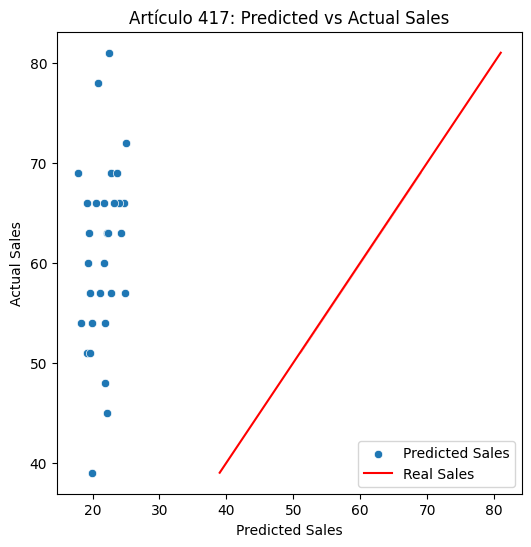

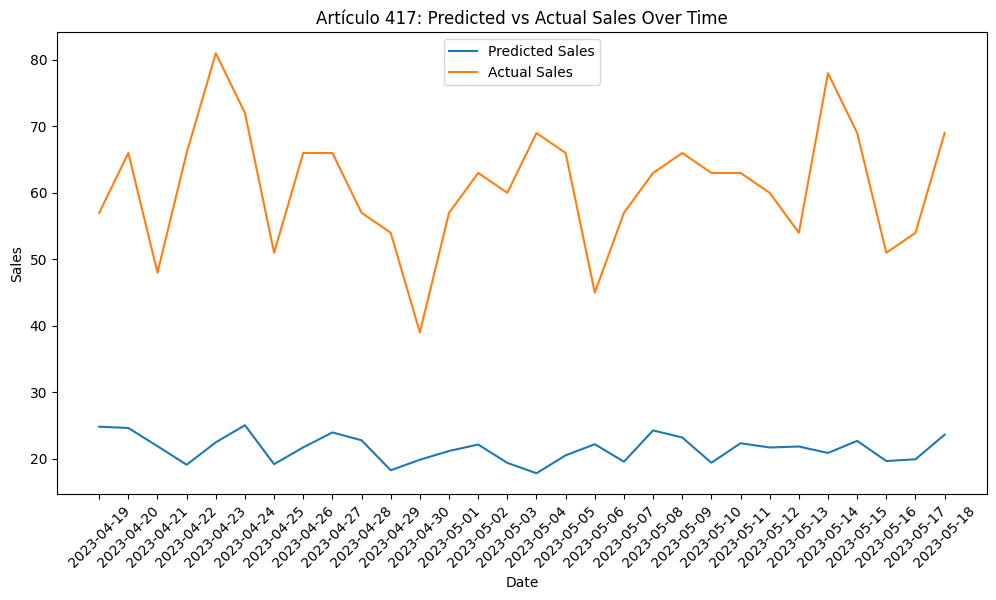


🎨 Graficando artículo 900...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


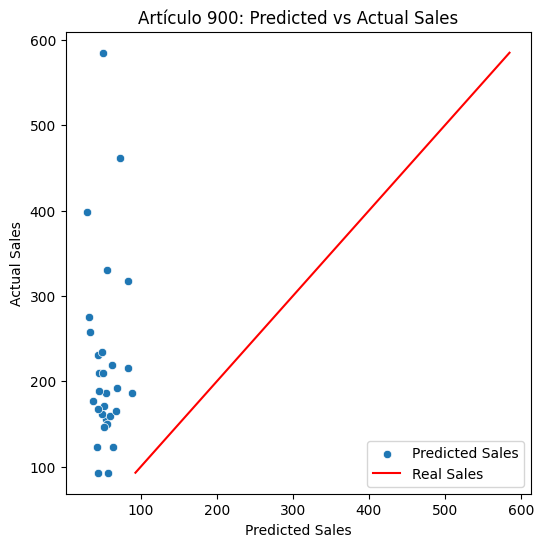

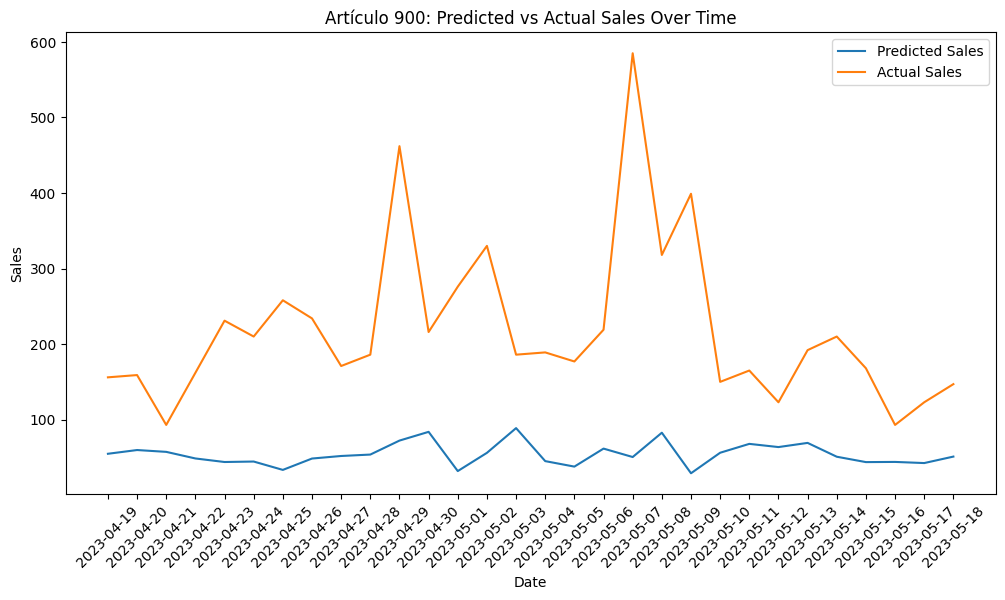


🎨 Graficando artículo 968...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


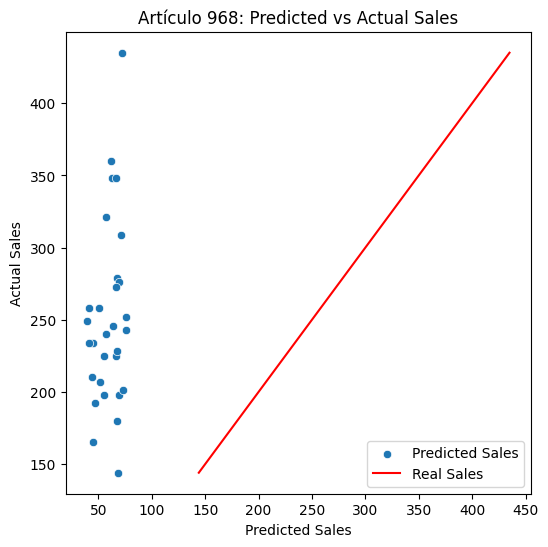

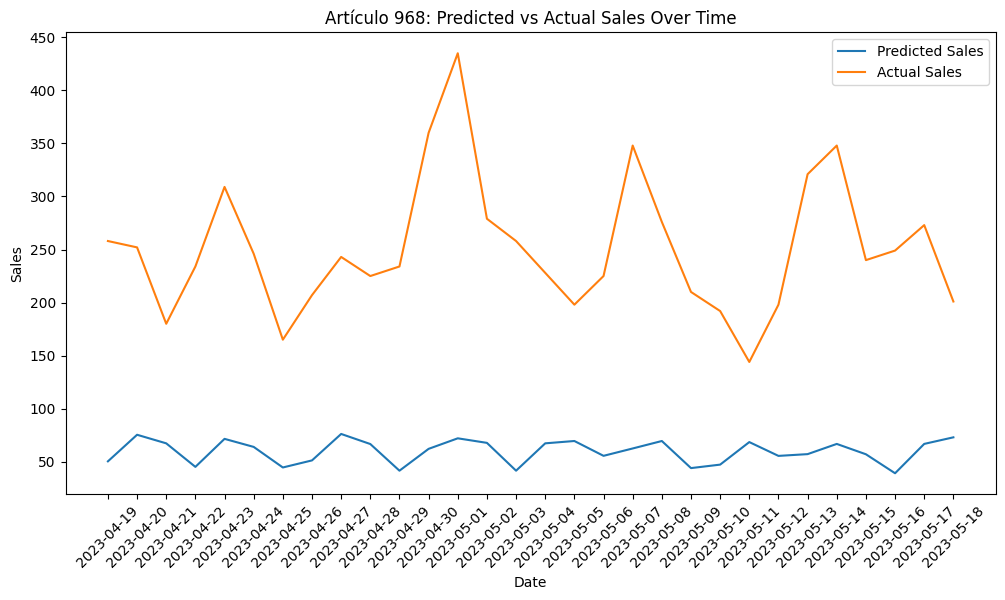


🎨 Graficando artículo 1043...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


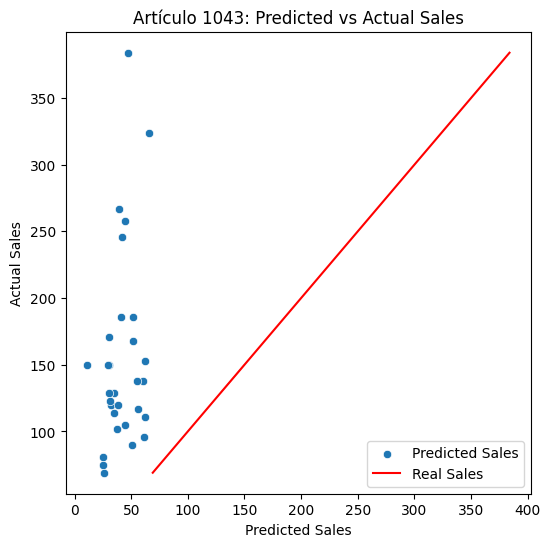

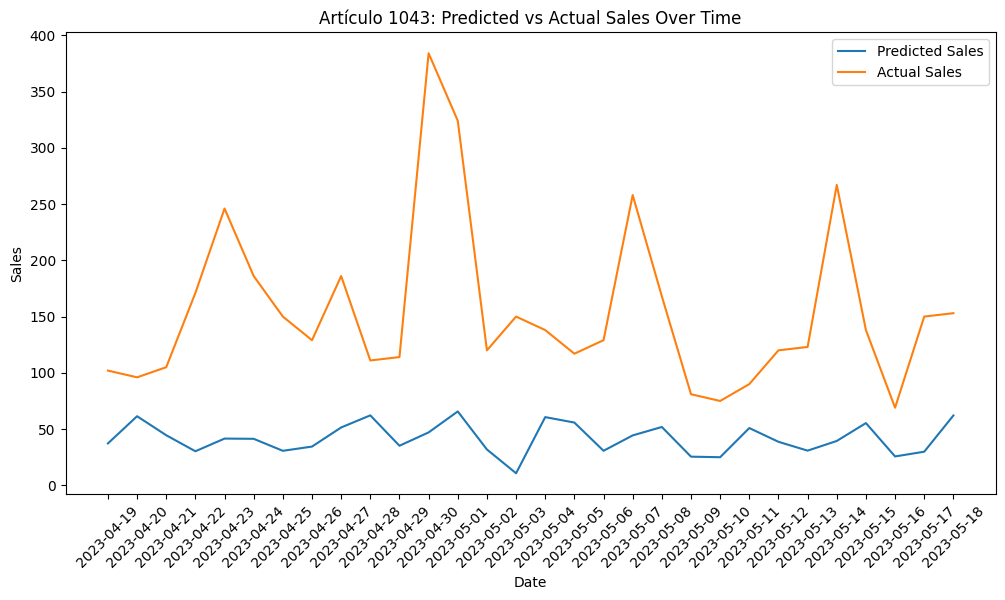


🎨 Graficando artículo 1084...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


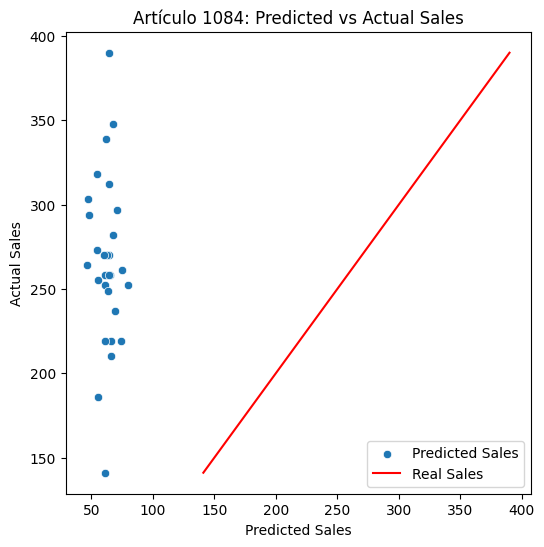

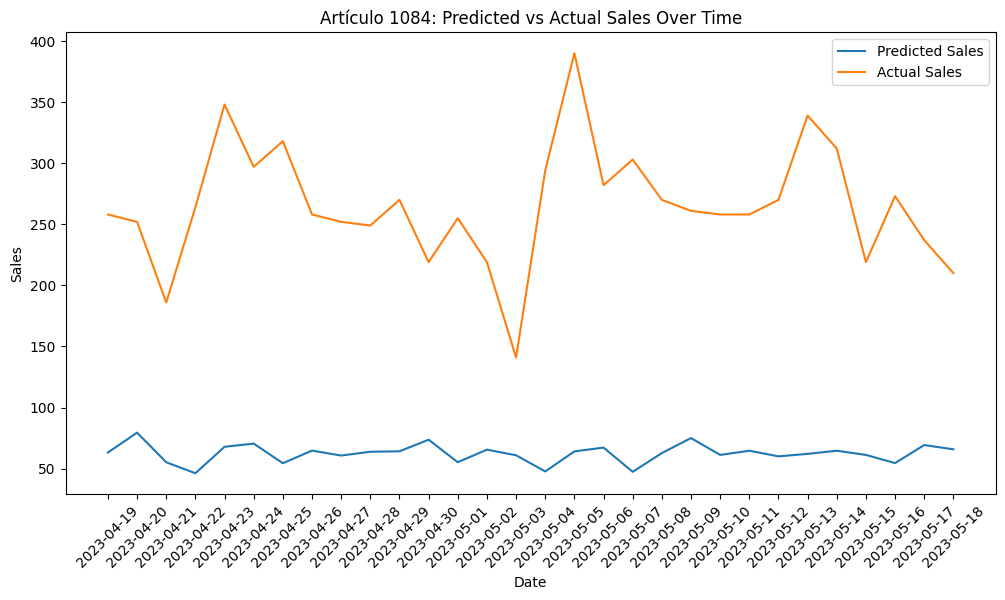


🎨 Graficando artículo 3880...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


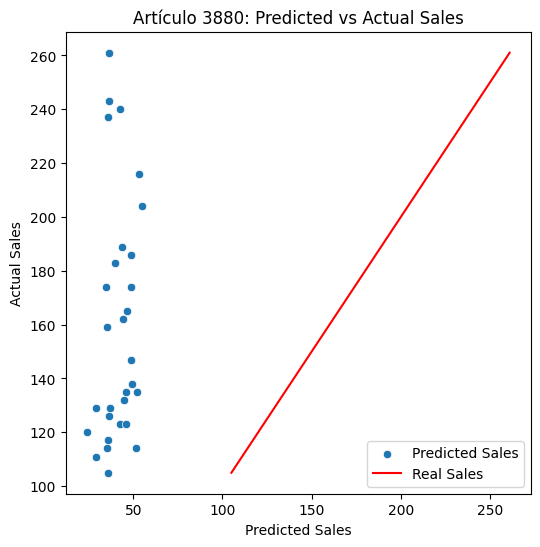

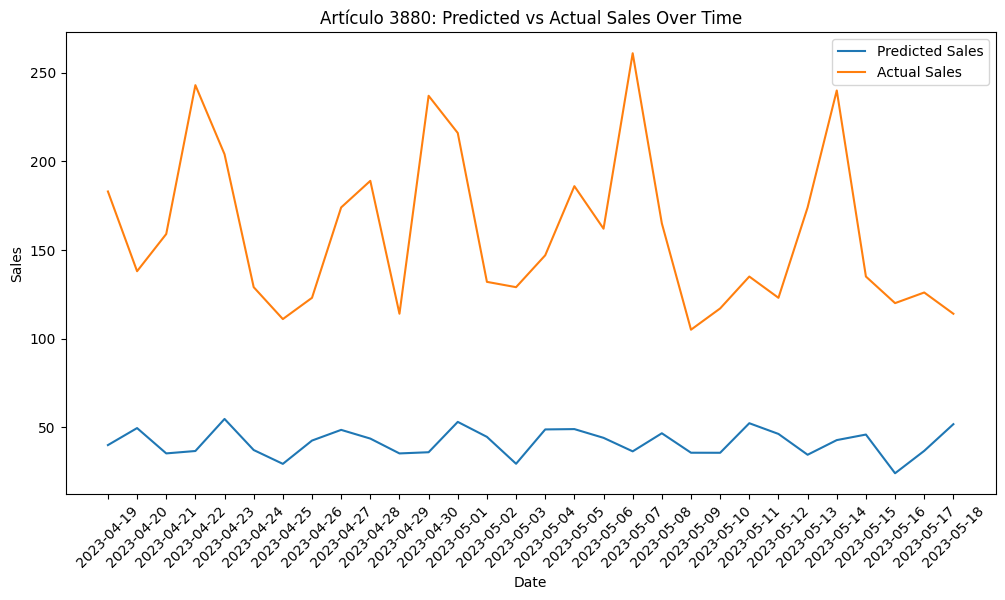


🎨 Graficando artículo 3960...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


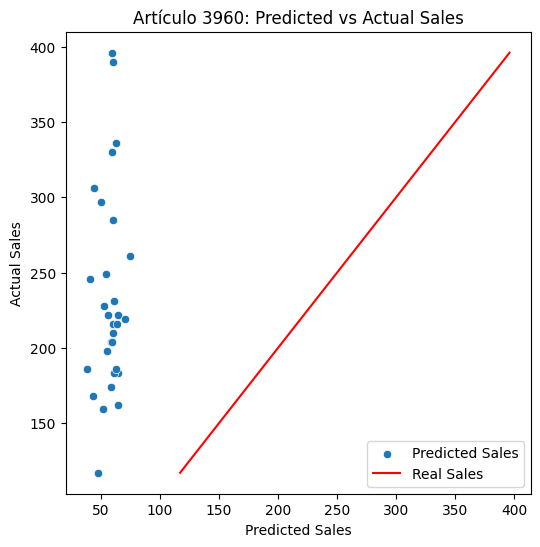

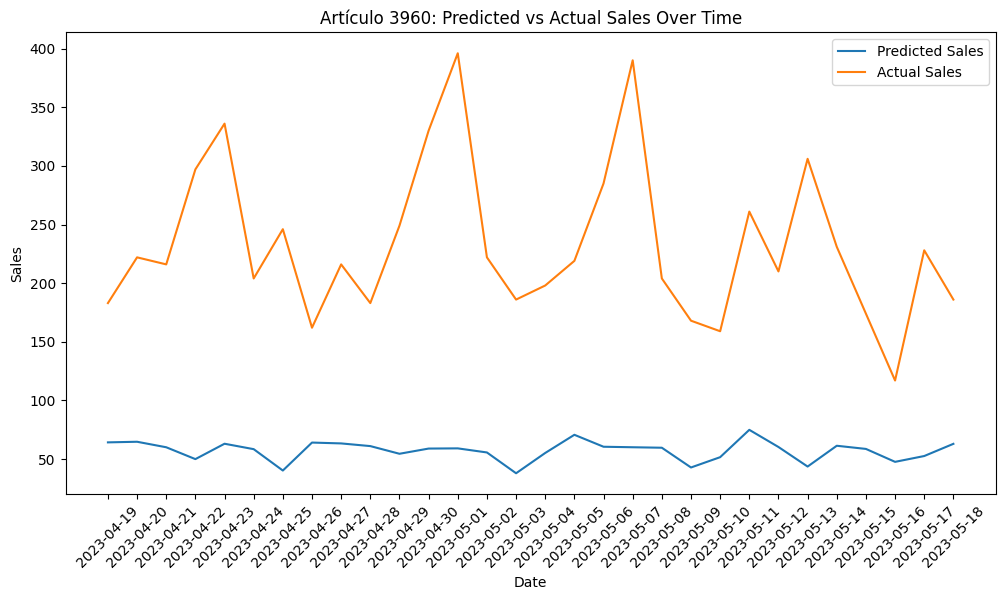


🎨 Graficando artículo 5403...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


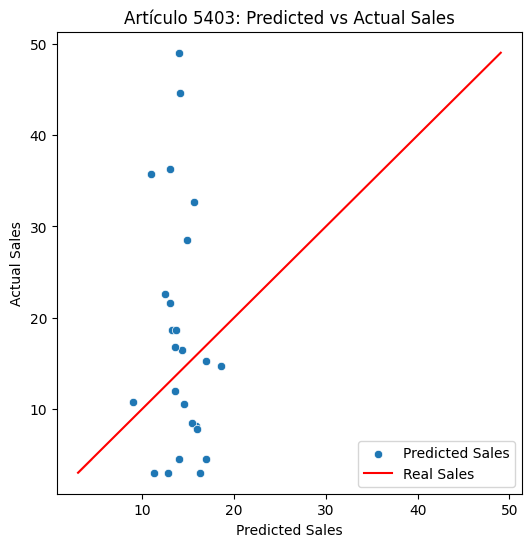

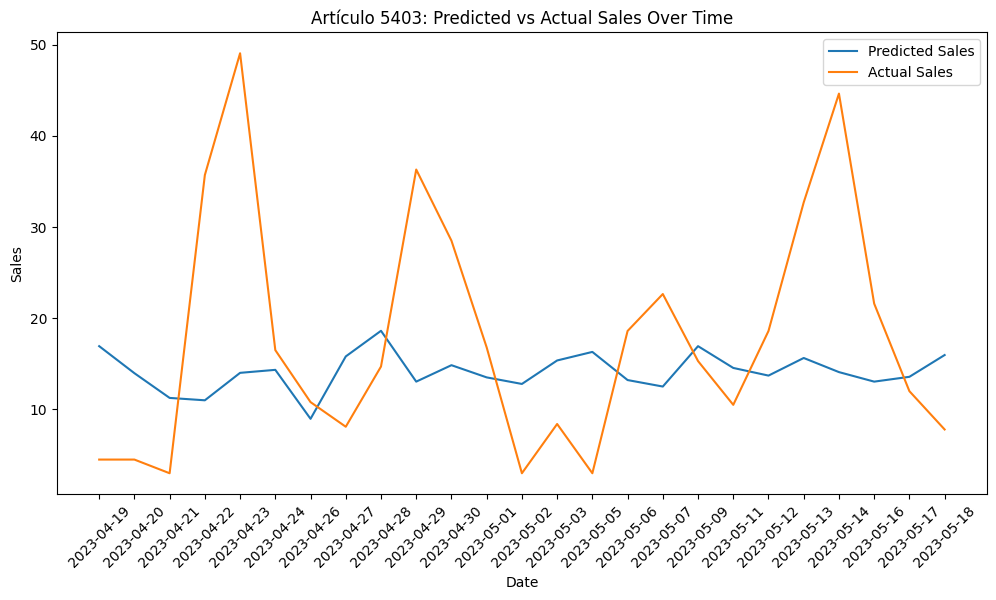


🎨 Graficando artículo 5404...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


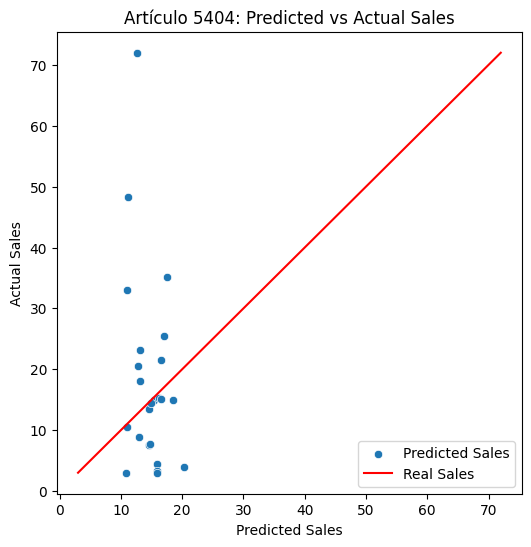

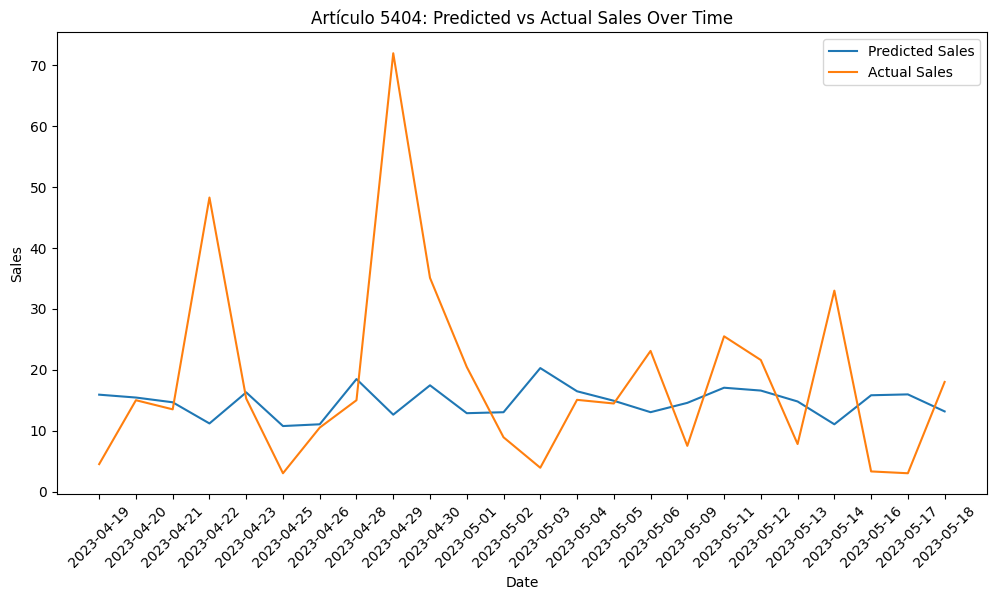


🎨 Graficando artículo 5803...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


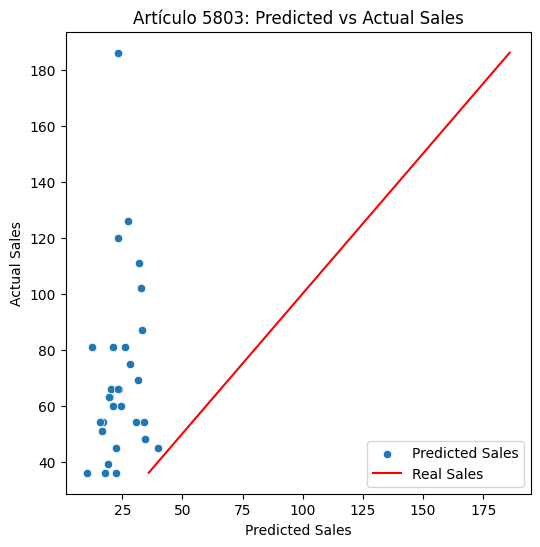

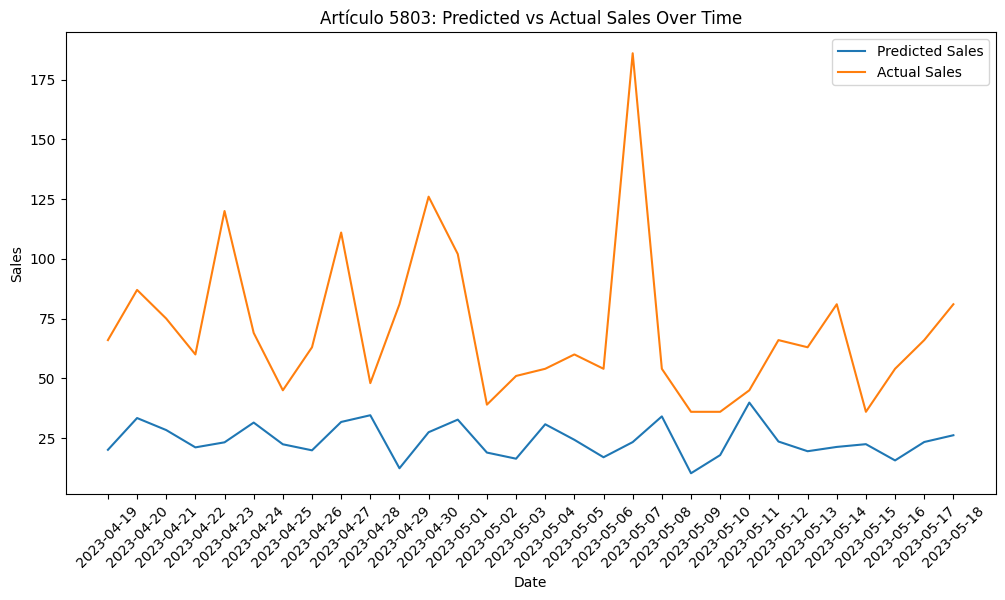


🎨 Graficando artículo 6286...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


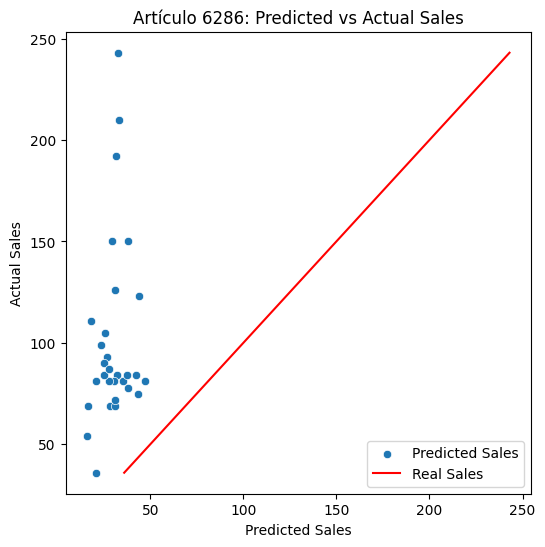

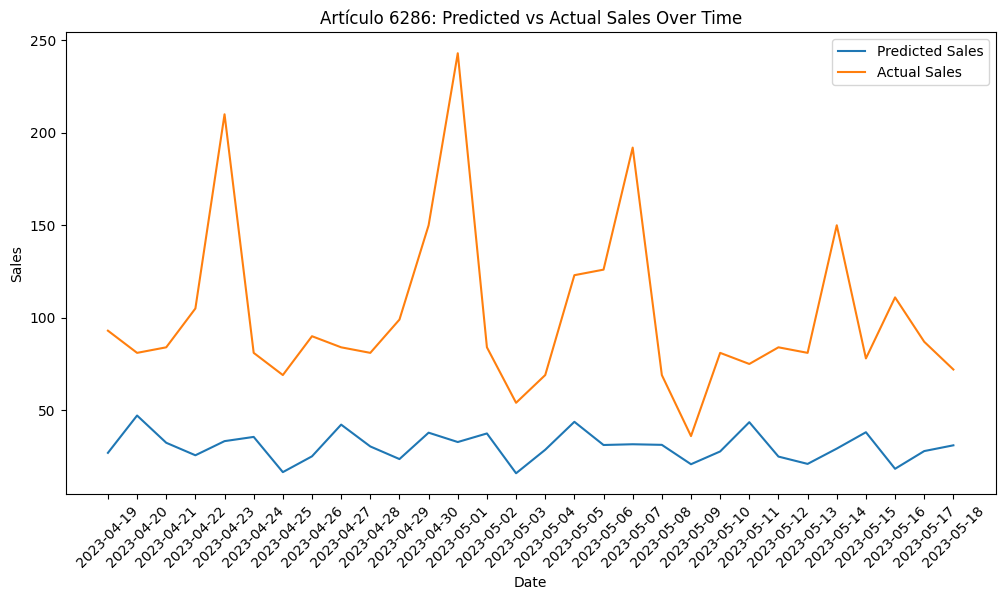


🎨 Graficando artículo 6425...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


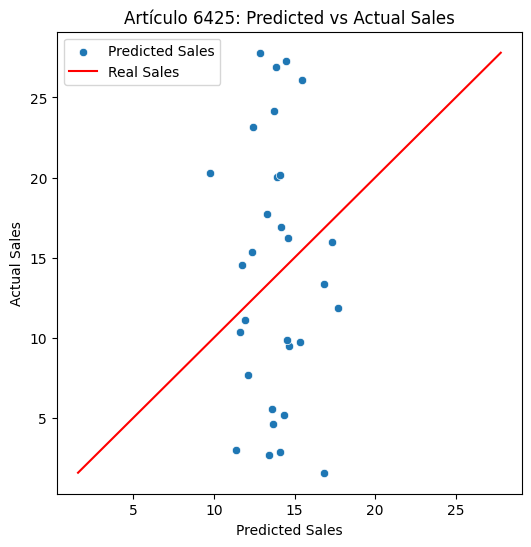

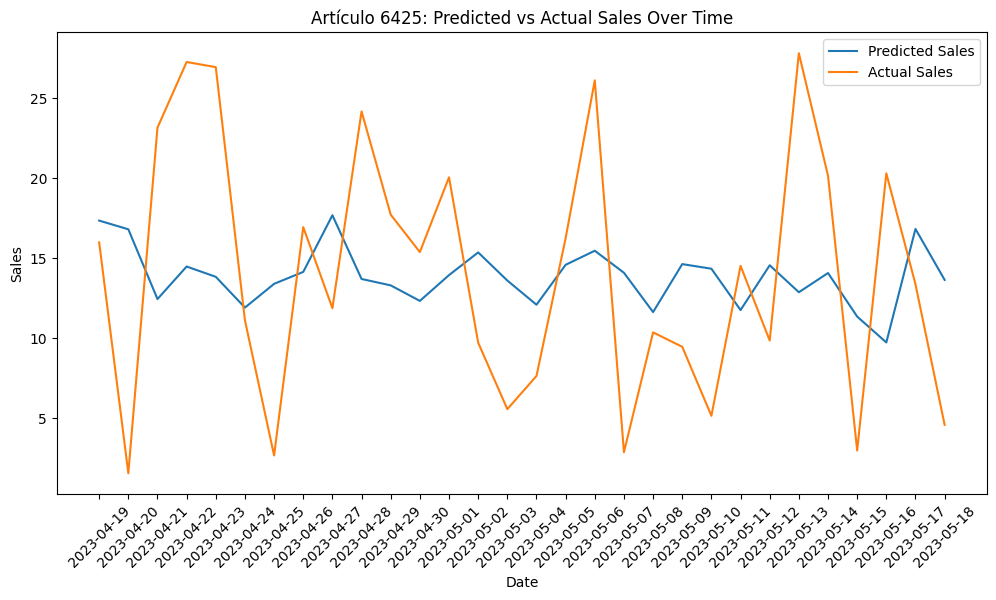


🎨 Graficando artículo 6451...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


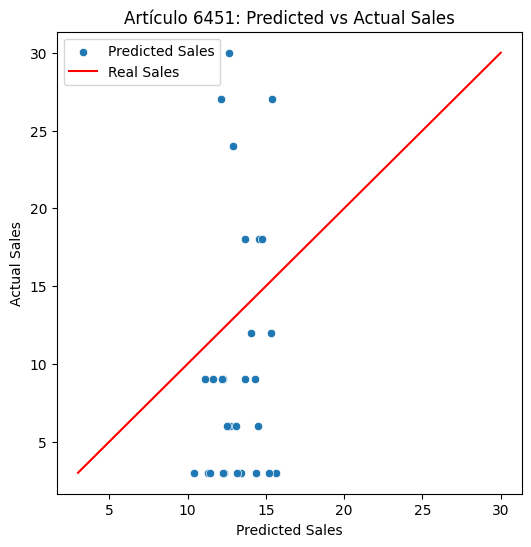

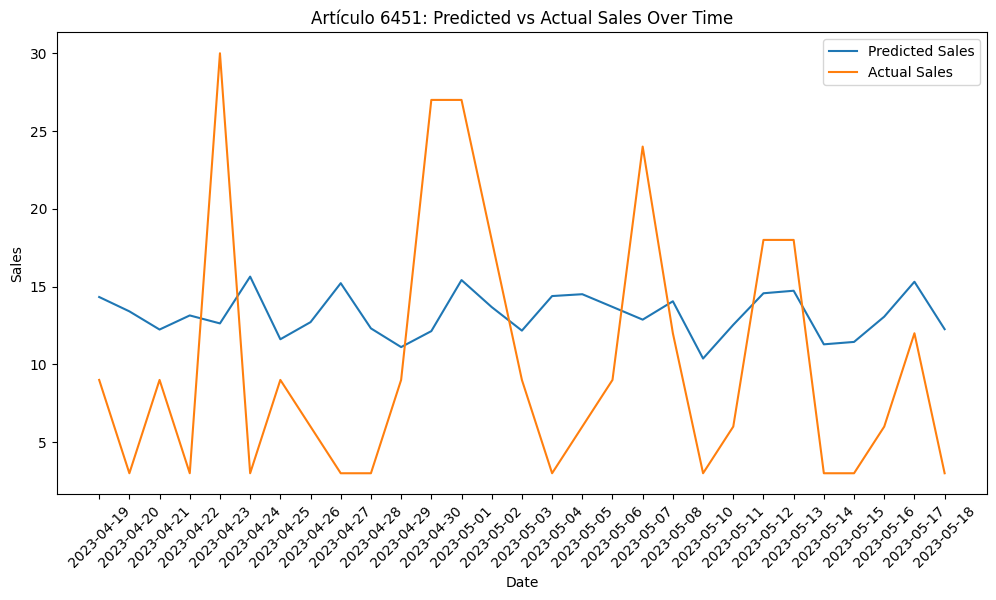


🎨 Graficando artículo 6523...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


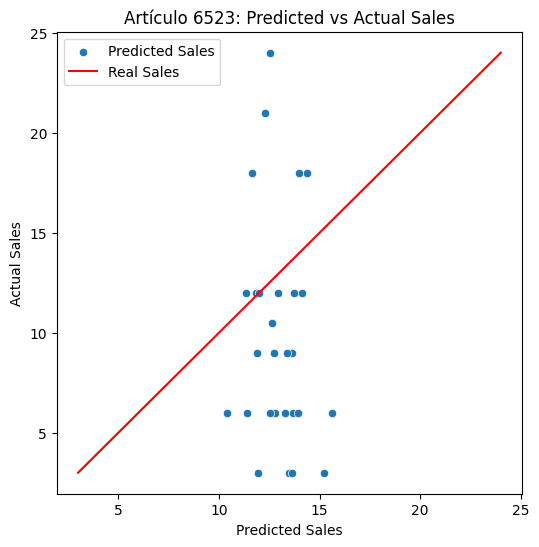

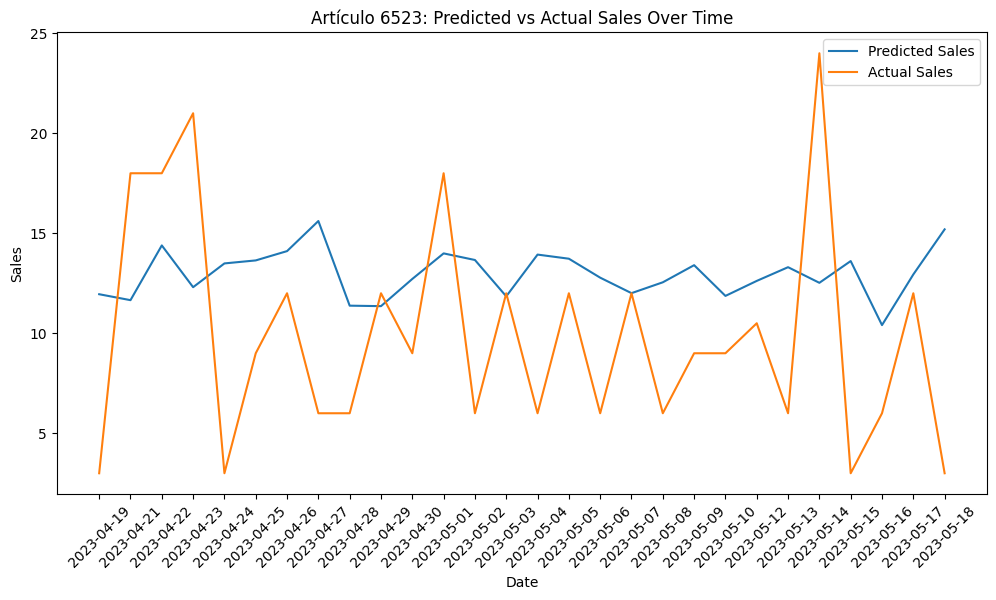


🎨 Graficando artículo 6549...
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


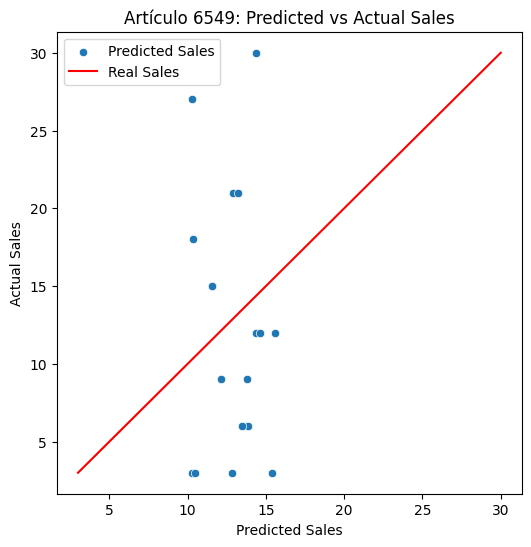

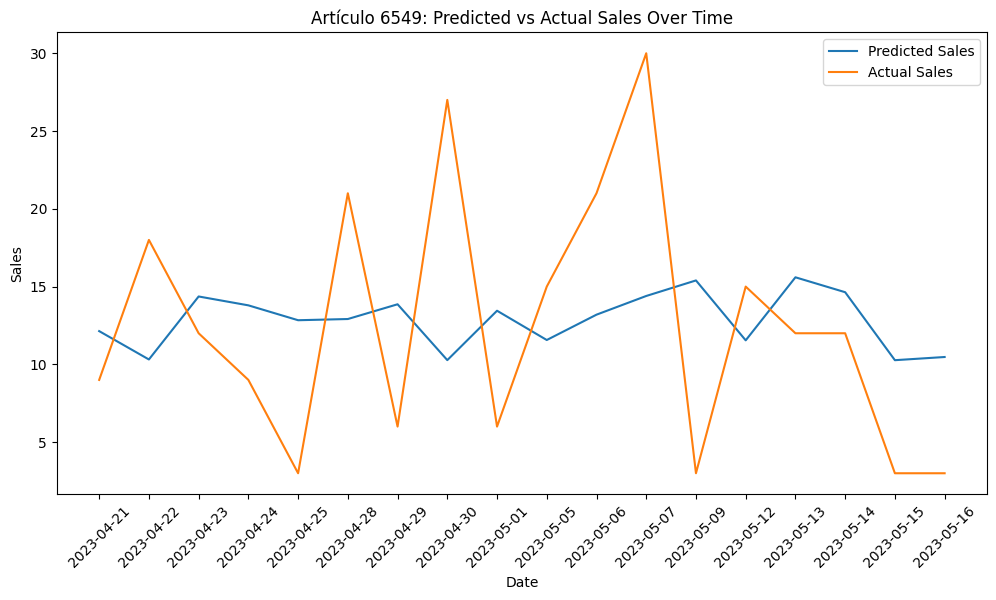

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

for id_articulo, datos_articulo in datos_preparados.items():
    print(f"\n🎨 Graficando artículo {id_articulo}...")

    X_test = datos_articulo["X_test"]
    y_test = datos_articulo["y_test"]

    if len(X_test) == 0:
        print(f"⚠️ Artículo {id_articulo}: No hay datos de prueba para graficar.")
        continue

    # Predicción usando el modelo ya entrenado
    y_pred = final_pipeline.predict(X_test)

    # Obtener fechas para gráfico temporal (debe estar en el dataframe original)
    fechas = dfs_articulos[id_articulo].loc[X_test.index, 'fecha_venta'].astype(str)

    # --- Gráfico 1: Predicted vs Actual (scatter) ---
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(f"Artículo {id_articulo}: Predicted vs Actual Sales")
    ax.set_xlabel("Predicted Sales")
    ax.set_ylabel("Actual Sales")

    sns.scatterplot(x=y_pred, y=y_test, ax=ax, label="Predicted Sales")
    sns.lineplot(x=y_test, y=y_test, color="red", ax=ax, label="Real Sales")
    plt.legend()
    plt.show()

    # --- Gráfico 2: Evolución temporal ---
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f"Artículo {id_articulo}: Predicted vs Actual Sales Over Time")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.set_xticklabels(fechas, rotation=45)

    sns.lineplot(x=fechas, y=y_pred, label="Predicted Sales", ax=ax)
    sns.lineplot(x=fechas, y=y_test, label="Actual Sales", ax=ax)
    plt.legend()
    plt.show()


### Conclusiones del modelo

El modelo `LinearRegression`, no ha sido preciso en las predicciones, tal vez porque el tiempo que se utilizó fue de 30 días, o porque se debe de eliminar algunas columnas que no favorecen para entrenar este modelo.

### Se correrá el modelo por producto

#### Filtrar el modelo por artículo

In [41]:
def add_holiday_column(df: pd.DataFrame, holiday_column_name: str = "festivo") -> pd.DataFrame:
    df["isHoliday"]  = ~df[holiday_column_name].isna()
    df.drop(columns=["festivo"], inplace=True)
    return df

df_supervised_tmp = add_holiday_column(df_supervised.copy())
df_supervised_tmp.head()

familia  articulo fecha_venta  precio  cantidad     importe  \
0  PANADERIA       417  2021-05-01   4.038      72.0  290.736004   
1  PANADERIA       417  2021-05-02   4.038      81.0  327.077995   
2  PANADERIA       417  2021-05-03   4.038      90.0  363.419998   
3  PANADERIA       417  2021-05-04   4.038      84.0  339.192001   
4  PANADERIA       417  2021-05-05   4.038      84.0  339.192003   

   orden_articulo_familia  cantidad_lag_1_weeks  cantidad_lag_2_weeks  \
0                       5                   NaN                   NaN   
1                       5                   NaN                   NaN   
2                       5                   NaN                   NaN   
3                       5                   NaN                   NaN   
4                       5                   NaN                   NaN   

   cantidad_lag_3_weeks  cantidad_lag_4_weeks  cantidad_lag_1_days  \
0                   NaN                   NaN                  NaN   
1                   NaN                   NaN                 72.0   
2                   NaN                   NaN                 81.0   
3                   NaN                   NaN                 90.0   
4                   NaN                   NaN                 84.0   

   cantidad_lag_2_days  cantidad_lag_3_days  cantidad_lag_4_days  \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   
2                 72.0                  NaN                  NaN   
3                 81.0                 72.0                  NaN   
4                 90.0                 81.0                 72.0   

   cantidad_lag_5_days  cantidad_lag_6_days  isHoliday  
0                  NaN                  NaN      False  
1                  NaN                  NaN       True  
2                  NaN                  NaN       True  
3                  NaN                  NaN      False  
4                  NaN                  NaN      False

### Procesamiento de datos de entrada

In [42]:
PRODUCT_6549 = 6549
PRODUCT_6523 = 6523
PRODUCT_6451 = 6451
PRODUCT_6425 = 6425
PRODUCT_6286 = 6286 
PRODUCT_5803 = 5803 
PRODUCT_5404 = 5404
PRODUCT_5403 = 5403
PRODUCT_3960 = 3960
PRODUCT_3880 = 3880 
PRODUCT_1084 = 1084 
PRODUCT_1043 = 1043 
PRODUCT_968 = 968 
PRODUCT_900 = 900 
PRODUCT_417 = 417

item_mask_6549 = df["articulo"] == PRODUCT_6549
item_mask_6523 = df["articulo"] == PRODUCT_6523
item_mask_6451 = df["articulo"] == PRODUCT_6451
item_mask_6425 = df["articulo"] == PRODUCT_6425
item_mask_6286 = df["articulo"] == PRODUCT_6286
item_mask_5803 = df["articulo"] == PRODUCT_5803
item_mask_5404 = df["articulo"] == PRODUCT_5404
item_mask_5403 = df["articulo"] == PRODUCT_5403
item_mask_3960 = df["articulo"] == PRODUCT_3960
item_mask_3880 = df["articulo"] == PRODUCT_3880
item_mask_1084 = df["articulo"] == PRODUCT_1084
item_mask_1043 = df["articulo"] == PRODUCT_1043
item_mask_968 = df["articulo"] == PRODUCT_968
item_mask_900 = df["articulo"] == PRODUCT_900
item_mask_417 = df["articulo"] == PRODUCT_417

item_df_6549 = df[item_mask_6549].copy()
item_df_6523 = df[item_mask_6523].copy()
item_df_6451 = df[item_mask_6451].copy()
item_df_6425 = df[item_mask_6425].copy()
item_df_6286 = df[item_mask_6286].copy()
item_df_5803 = df[item_mask_5803].copy()
item_df_5404 = df[item_mask_5404].copy()
item_df_5403 = df[item_mask_5403].copy()
item_df_3960 = df[item_mask_3960].copy()
item_df_3880 = df[item_mask_3880].copy()
item_df_1084 = df[item_mask_1084].copy()
item_df_1043 = df[item_mask_1043].copy()
item_df_968 = df[item_mask_968].copy()
item_df_900 = df[item_mask_900].copy()
item_df_417 = df[item_mask_417].copy()

In [43]:
# Se regorganiza la fecha y el index

item_df_6549.sort_values("fecha_venta", inplace=True)
item_df_6523.sort_values("fecha_venta", inplace=True)
item_df_6451.sort_values("fecha_venta", inplace=True)
item_df_6425.sort_values("fecha_venta", inplace=True)
item_df_6286.sort_values("fecha_venta", inplace=True)
item_df_5803.sort_values("fecha_venta", inplace=True)
item_df_5404.sort_values("fecha_venta", inplace=True)
item_df_5403.sort_values("fecha_venta", inplace=True)
item_df_3960.sort_values("fecha_venta", inplace=True)
item_df_3880.sort_values("fecha_venta", inplace=True)
item_df_1084.sort_values("fecha_venta", inplace=True)
item_df_1043.sort_values("fecha_venta", inplace=True)
item_df_968.sort_values("fecha_venta", inplace=True)
item_df_900.sort_values("fecha_venta", inplace=True)
item_df_417.sort_values("fecha_venta", inplace=True)

item_df_6549.reset_index(inplace=True, drop=True)
item_df_6523.reset_index(inplace=True, drop=True)
item_df_6451.reset_index(inplace=True, drop=True)
item_df_6425.reset_index(inplace=True, drop=True)
item_df_6286.reset_index(inplace=True, drop=True)
item_df_5803.reset_index(inplace=True, drop=True)
item_df_5404.reset_index(inplace=True, drop=True)
item_df_5403.reset_index(inplace=True, drop=True)
item_df_3960.reset_index(inplace=True, drop=True)
item_df_3880.reset_index(inplace=True, drop=True)
item_df_1084.reset_index(inplace=True, drop=True)
item_df_1043.reset_index(inplace=True, drop=True)
item_df_968.reset_index(inplace=True, drop=True)
item_df_900.reset_index(inplace=True, drop=True)
item_df_417.reset_index(inplace=True, drop=True)

item_df_417.head()


familia  articulo fecha_venta          festivo  precio  cantidad  \
0  PANADERIA       417  2021-05-01             None   4.038      72.0   
1  PANADERIA       417  2021-05-02  Día de la Madre   4.038      81.0   
2  PANADERIA       417  2021-05-03   Día de la Cruz   4.038      90.0   
3  PANADERIA       417  2021-05-04             None   4.038      84.0   
4  PANADERIA       417  2021-05-05             None   4.038      84.0   

      importe  orden_articulo_familia  
0  290.736004                       5  
1  327.077995                       5  
2  363.419998                       5  
3  339.192001                       5  
4  339.192003                       5

In [44]:
product_family_6549 = item_df_6549["familia"][0]
product_family_6523 = item_df_6523["familia"][0]
product_family_6451 = item_df_6451["familia"][0]
product_family_6425 = item_df_6425["familia"][0]
product_family_6286 = item_df_6286["familia"][0]
product_family_5803 = item_df_5803["familia"][0]
product_family_5404 = item_df_5404["familia"][0]
product_family_5403 = item_df_5403["familia"][0]
product_family_3960 = item_df_3960["familia"][0]
product_family_3880 = item_df_3880["familia"][0]
product_family_1084 = item_df_1084["familia"][0]
product_family_1043 = item_df_1043["familia"][0]
product_family_968 = item_df_968["familia"][0]
product_family_900 = item_df_900["familia"][0]
product_family_417 = item_df_417["familia"][0]


In [45]:
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin


class PreprocessTransformer(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self, location: tuple[int, int], daily_lag: int, weekly_lag: int):
        self.location = location
        self.daily_lag = daily_lag
        self.weekly_lag = weekly_lag

    def fit(self, X: pd.DataFrame, y: pd.Series | None = None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()  # avoid modifying incoming data
        X = add_date_columns(X)
        X = add_holiday_features(X)
        X = add_weather_columns(X, location=self.location)
        return X

In [46]:
# Articulo 6549
preprocessor_6549 = PreprocessTransformer(location=LOCATION, daily_lag=6, weekly_lag=4)
preprocessed_df_6549 = preprocessor_6549.transform(item_df_6549)


# Articulo 6523
preprocessor_6523 = PreprocessTransformer(location=LOCATION, daily_lag=6, weekly_lag=4)
preprocessed_df_6523 = preprocessor_6523.transform(item_df_6523)


# Articulo 6451
preprocessor_6451 = PreprocessTransformer(location=LOCATION, daily_lag=6, weekly_lag=4)
preprocessed_df_6451 = preprocessor_6451.transform(item_df_6451)


# Articulo 6425
preprocessor_6425 = PreprocessTransformer(location=LOCATION, daily_lag=6, weekly_lag=4)
preprocessed_df_6425 = preprocessor_6425.transform(item_df_6425)


# Articulo 6286
preprocessor_6286 = PreprocessTransformer(location=LOCATION, daily_lag=6, weekly_lag=4)
preprocessed_df_6286 = preprocessor_6286.transform(item_df_6286)


# Articulo 5803
preprocessor_5803 = PreprocessTransformer(location=LOCATION, daily_lag=6, weekly_lag=4)
preprocessed_df_5803 = preprocessor_5803.transform(item_df_5803)


# Articulo 5404
preprocessor_5404 = PreprocessTransformer(location=LOCATION, daily_lag=6, weekly_lag=4)
preprocessed_df_5404 = preprocessor_5404.transform(item_df_5404)


# Articulo 5403
preprocessor_5403 = PreprocessTransformer(location=LOCATION, daily_lag=6, weekly_lag=4)
preprocessed_df_5403 = preprocessor_5403.transform(item_df_5403)


# Articulo 3960
preprocessor_3960 = PreprocessTransformer(location=LOCATION, daily_lag=6, weekly_lag=4)
preprocessed_df_3960 = preprocessor_3960.transform(item_df_3960)


# Articulo 3880
preprocessor_3880 = PreprocessTransformer(location=LOCATION, daily_lag=6, weekly_lag=4)
preprocessed_df_3880 = preprocessor_3880.transform(item_df_3880)


# Articulo 1084
preprocessor_1084 = PreprocessTransformer(location=LOCATION, daily_lag=6, weekly_lag=4)
preprocessed_df_1084 = preprocessor_1084.transform(item_df_1084)


# Articulo 1043
preprocessor_1043 = PreprocessTransformer(location=LOCATION, daily_lag=6, weekly_lag=4)
preprocessed_df_1043 = preprocessor_1043.transform(item_df_1043)


# Articulo 968
preprocessor_968 = PreprocessTransformer(location=LOCATION, daily_lag=6, weekly_lag=4)
preprocessed_df_968 = preprocessor_968.transform(item_df_968)


# Articulo 900
preprocessor_900 = PreprocessTransformer(location=LOCATION, daily_lag=6, weekly_lag=4)
preprocessed_df_900 = preprocessor_900.transform(item_df_900)


# Articulo 417
preprocessor_417 = PreprocessTransformer(location=LOCATION, daily_lag=6, weekly_lag=4)
preprocessed_df_417 = preprocessor_417.transform(item_df_417)
preprocessed_df_417.info()


<class 'pandas.core.frame.DataFrame'>
Index: 748 entries, 0 to 747
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   familia                 748 non-null    object        
 1   articulo                748 non-null    int64         
 2   fecha_venta             748 non-null    datetime64[ns]
 3   precio                  748 non-null    float64       
 4   cantidad                748 non-null    float64       
 5   importe                 748 non-null    float64       
 6   orden_articulo_familia  748 non-null    int64         
 7   day                     748 non-null    int32         
 8   month                   748 non-null    int32         
 9   year                    748 non-null    int32         
 10  dayofweek               748 non-null    int32         
 11  isWeekend               748 non-null    bool          
 12  isHoliday               748 non-null    bool          


In [47]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector


categorical_features = make_column_selector(dtype_include=[object, np.int32])
numerical_features = make_column_selector(dtype_include=[np.float64])

ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
minmax_scaler = MinMaxScaler(feature_range=(0, 1))

encoders_transformer = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", ohe_encoder, categorical_features),
        ("MinMaxScaler", minmax_scaler, numerical_features),
    ],
)

In [48]:
from sklearn.linear_model import LinearRegression


model = LinearRegression()

In [49]:
from sklearn.pipeline import Pipeline


input_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("nan_remover", remove_nans_transformer),
        ("data_encoding", encoders_transformer),
        ("model", model),
    ]
)

input_pipeline.set_output(transform="pandas")

Pipeline(steps=[('preprocessor',
                 PreprocessTransformer(daily_lag=6,
                                       location=(36.721477644071705,
                                                 -4.363132134392174),
                                       weekly_lag=4)),
                ('nan_remover',
                 ColumnTransformer(transformers=[('RemoveNans', SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D6EE2BF4D0>)])),
                ('data_encoding',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D6ECEA9350>),
                                                 ('MinMaxScaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D68C54EAD0>)])),
                ('model', LinearRegression())])

In [50]:
from sklearn.compose import TransformedTargetRegressor


target_feature_scaler = MinMaxScaler(feature_range=(0,1))
final_pipeline = TransformedTargetRegressor(
    regressor=input_pipeline,
    transformer=target_feature_scaler,
)
final_pipeline

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      PreprocessTransformer(daily_lag=6,
                                                                            location=(36.721477644071705,
                                                                                      -4.363132134392174),
                                                                            weekly_lag=4)),
                                                     ('nan_remover',
                                                      ColumnTransformer(transformers=[('RemoveNans',
                                                                                       SimpleImputer(),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x000001D6EE2BF4D0>)])),
                                                     ('data_encoding',
                                                      ColumnTransformer(transformers=[('OneHotEncoder',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x000001D6ECEA9350>),
                                                                                      ('MinMaxScaler',
                                                                                       MinMaxScaler(),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x000001D68C54EAD0>)])),
                                                     ('model',
                                                      LinearRegression())]),
                           transformer=MinMaxScaler())

### Eliminar valores nulos

In [51]:
from sklearn.impute import SimpleImputer


nans_remover = SimpleImputer(strategy="mean")
remove_nans_transformer = ColumnTransformer(
    transformers=[
        ("RemoveNans", nans_remover, numerical_features),
    ],
)


### Entrenar modelos por producto

In [52]:
# Se definen los productos a filtrar
PRODUCT_6549 = 6549
PRODUCT_6523 = 6523
PRODUCT_6451 = 6451
PRODUCT_6425 = 6425
PRODUCT_6286 = 6286 
PRODUCT_5803 = 5803 
PRODUCT_5404 = 5404
PRODUCT_5403 = 5403
PRODUCT_3960 = 3960
PRODUCT_3880 = 3880 
PRODUCT_1084 = 1084 
PRODUCT_1043 = 1043 
PRODUCT_968 = 968 
PRODUCT_900 = 900 
PRODUCT_417 = 417

item_mask_6549 = df_supervised["articulo"] == PRODUCT_6549
item_mask_6523 = df_supervised["articulo"] == PRODUCT_6523
item_mask_6451 = df_supervised["articulo"] == PRODUCT_6451
item_mask_6425 = df_supervised["articulo"] == PRODUCT_6425
item_mask_6286 = df_supervised["articulo"] == PRODUCT_6286
item_mask_5803 = df_supervised["articulo"] == PRODUCT_5803
item_mask_5404 = df_supervised["articulo"] == PRODUCT_5404
item_mask_5403 = df_supervised["articulo"] == PRODUCT_5403
item_mask_3960 = df_supervised["articulo"] == PRODUCT_3960
item_mask_3880 = df_supervised["articulo"] == PRODUCT_3880
item_mask_1084 = df_supervised["articulo"] == PRODUCT_1084
item_mask_1043 = df_supervised["articulo"] == PRODUCT_1043
item_mask_968 = df_supervised["articulo"] == PRODUCT_968
item_mask_900 = df_supervised["articulo"] == PRODUCT_900
item_mask_417 = df_supervised["articulo"] == PRODUCT_417

item_df_6549 = df_supervised[item_mask_6549].copy()
item_df_6523 = df_supervised[item_mask_6523].copy()
item_df_6451 = df_supervised[item_mask_6451].copy()
item_df_6425 = df_supervised[item_mask_6425].copy()
item_df_6286 = df_supervised[item_mask_6286].copy()
item_df_5803 = df_supervised[item_mask_5803].copy()
item_df_5404 = df_supervised[item_mask_5404].copy()
item_df_5403 = df_supervised[item_mask_5403].copy()
item_df_3960 = df_supervised[item_mask_3960].copy()
item_df_3880 = df_supervised[item_mask_3880].copy()
item_df_1084 = df_supervised[item_mask_1084].copy()
item_df_1043 = df_supervised[item_mask_1043].copy()
item_df_968 = df_supervised[item_mask_968].copy()
item_df_900 = df_supervised[item_mask_900].copy()
item_df_417 = df_supervised[item_mask_417].copy()



In [53]:
item_df_417.info()

<class 'pandas.core.frame.DataFrame'>
Index: 748 entries, 0 to 747
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   familia                 748 non-null    object        
 1   articulo                748 non-null    int64         
 2   fecha_venta             748 non-null    datetime64[ns]
 3   festivo                 59 non-null     object        
 4   precio                  748 non-null    float64       
 5   cantidad                748 non-null    float64       
 6   importe                 748 non-null    float64       
 7   orden_articulo_familia  748 non-null    int64         
 8   cantidad_lag_1_weeks    741 non-null    float64       
 9   cantidad_lag_2_weeks    734 non-null    float64       
 10  cantidad_lag_3_weeks    727 non-null    float64       
 11  cantidad_lag_4_weeks    720 non-null    float64       
 12  cantidad_lag_1_days     747 non-null    float64       


In [54]:
# Limpieza de datos

item_df_6549.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True)
item_df_6523.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True)
item_df_6451.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True)
item_df_6425.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True)
item_df_6286.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True)
item_df_5803.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True)
item_df_5404.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True)
item_df_5403.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True)
item_df_3960.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True)
item_df_3880.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True)
item_df_1084.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True)
item_df_1043.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True)
item_df_968.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True)
item_df_900.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True) 
item_df_417.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True) 

In [55]:
item_df_417.head()

fecha_venta          festivo  precio  cantidad  cantidad_lag_1_weeks  \
0  2021-05-01             None   4.038      72.0                   NaN   
1  2021-05-02  Día de la Madre   4.038      81.0                   NaN   
2  2021-05-03   Día de la Cruz   4.038      90.0                   NaN   
3  2021-05-04             None   4.038      84.0                   NaN   
4  2021-05-05             None   4.038      84.0                   NaN   

   cantidad_lag_2_weeks  cantidad_lag_3_weeks  cantidad_lag_4_weeks  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   

   cantidad_lag_1_days  cantidad_lag_2_days  cantidad_lag_3_days  \
0                  NaN                  NaN                  NaN   
1                 72.0                  NaN                  NaN   
2                 81.0                 72.0                  NaN   
3                 90.0                 81.0                 72.0   
4                 84.0                 90.0                 81.0   

   cantidad_lag_4_days  cantidad_lag_5_days  cantidad_lag_6_days  
0                  NaN                  NaN                  NaN  
1                  NaN                  NaN                  NaN  
2                  NaN                  NaN                  NaN  
3                  NaN                  NaN                  NaN  
4                 72.0                  NaN                  NaN

In [56]:
# Dividir el modelo en conjunto de entrenamiento y prueba

horizont = datetime(2023,4,19)

# Articulo 6549
df_train_6549 = item_df_6549.loc[item_df_6549["fecha_venta"]<horizont]
df_test_6549 = item_df_6549.loc[item_df_6549["fecha_venta"]>=horizont]

X_train_6549 = df_train_6549.drop(columns=["cantidad"])
y_train_6549 = df_train_6549["cantidad"]
X_test_6549 = df_test_6549.drop(columns=["cantidad"])
y_test_6549 = df_test_6549["cantidad"]

# Articulo 6523
df_train_6523 = item_df_6523.loc[item_df_6523["fecha_venta"]<horizont]
df_test_6523 = item_df_6523.loc[item_df_6523["fecha_venta"]>=horizont]

X_train_6523 = df_train_6523.drop(columns=["cantidad"])
y_train_6523 = df_train_6523["cantidad"]
X_test_6523 = df_test_6523.drop(columns=["cantidad"])
y_test_6523 = df_test_6523["cantidad"]

# Articulo 6451
df_train_6451 = item_df_6451.loc[item_df_6451["fecha_venta"]<horizont]
df_test_6451 = item_df_6451.loc[item_df_6451["fecha_venta"]>=horizont]

X_train_6451 = df_train_6451.drop(columns=["cantidad"])
y_train_6451 = df_train_6451["cantidad"]
X_test_6451 = df_test_6451.drop(columns=["cantidad"])
y_test_6451 = df_test_6451["cantidad"]

# Articulo 6425
df_train_6425 = item_df_6425.loc[item_df_6425["fecha_venta"]<horizont]
df_test_6425 = item_df_6425.loc[item_df_6425["fecha_venta"]>=horizont]

X_train_6425 = df_train_6425.drop(columns=["cantidad"])
y_train_6425 = df_train_6425["cantidad"]
X_test_6425 = df_test_6425.drop(columns=["cantidad"])
y_test_6425 = df_test_6425["cantidad"]

# Articulo 6286
df_train_6286 = item_df_6286.loc[item_df_6286["fecha_venta"]<horizont]
df_test_6286 = item_df_6286.loc[item_df_6286["fecha_venta"]>=horizont]

X_train_6286 = df_train_6286.drop(columns=["cantidad"])
y_train_6286 = df_train_6286["cantidad"]
X_test_6286 = df_test_6286.drop(columns=["cantidad"])
y_test_6286 = df_test_6286["cantidad"]

# Articulo 5803
df_train_5803 = item_df_5803.loc[item_df_5803["fecha_venta"]<horizont]
df_test_5803 = item_df_5803.loc[item_df_5803["fecha_venta"]>=horizont]

X_train_5803 = df_train_5803.drop(columns=["cantidad"])
y_train_5803 = df_train_5803["cantidad"]
X_test_5803 = df_test_5803.drop(columns=["cantidad"])
y_test_5803 = df_test_5803["cantidad"]

# Articulo 5404
df_train_5404 = item_df_5404.loc[item_df_5404["fecha_venta"]<horizont]
df_test_5404 = item_df_5404.loc[item_df_5404["fecha_venta"]>=horizont]

X_train_5404 = df_train_5404.drop(columns=["cantidad"])
y_train_5404 = df_train_5404["cantidad"]
X_test_5404 = df_test_5404.drop(columns=["cantidad"])
y_test_5404 = df_test_5404["cantidad"]

# Articulo 5403
df_train_5403 = item_df_5403.loc[item_df_5403["fecha_venta"]<horizont]
df_test_5403 = item_df_5403.loc[item_df_5403["fecha_venta"]>=horizont]

X_train_5403 = df_train_5403.drop(columns=["cantidad"])
y_train_5403 = df_train_5403["cantidad"]
X_test_5403 = df_test_5403.drop(columns=["cantidad"])
y_test_5403 = df_test_5403["cantidad"]

# Articulo 3960
df_train_3960 = item_df_3960.loc[item_df_3960["fecha_venta"]<horizont]
df_test_3960 = item_df_3960.loc[item_df_3960["fecha_venta"]>=horizont]

X_train_3960 = df_train_3960.drop(columns=["cantidad"])
y_train_3960 = df_train_3960["cantidad"]
X_test_3960 = df_test_3960.drop(columns=["cantidad"])
y_test_3960 = df_test_3960["cantidad"]

# Articulo 3880
df_train_3880 = item_df_3880.loc[item_df_3880["fecha_venta"]<horizont]
df_test_3880 = item_df_3880.loc[item_df_3880["fecha_venta"]>=horizont]

X_train_3880 = df_train_3880.drop(columns=["cantidad"])
y_train_3880 = df_train_3880["cantidad"]
X_test_3880 = df_test_3880.drop(columns=["cantidad"])
y_test_3880 = df_test_3880["cantidad"]

# Articulo 1084
df_train_1084 = item_df_1084.loc[item_df_1084["fecha_venta"]<horizont]
df_test_1084 = item_df_1084.loc[item_df_1084["fecha_venta"]>=horizont]

X_train_1084 = df_train_1084.drop(columns=["cantidad"])
y_train_1084 = df_train_1084["cantidad"]
X_test_1084 = df_test_1084.drop(columns=["cantidad"])
y_test_1084 = df_test_1084["cantidad"]

# Articulo 1043
df_train_1043 = item_df_1043.loc[item_df_1043["fecha_venta"]<horizont]
df_test_1043 = item_df_1043.loc[item_df_1043["fecha_venta"]>=horizont]

X_train_1043 = df_train_1043.drop(columns=["cantidad"])
y_train_1043 = df_train_1043["cantidad"]
X_test_1043 = df_test_1043.drop(columns=["cantidad"])
y_test_1043 = df_test_1043["cantidad"]

# Articulo 968
df_train_968 = item_df_968.loc[item_df_968["fecha_venta"]<horizont]
df_test_968 = item_df_968.loc[item_df_968["fecha_venta"]>=horizont]

X_train_968 = df_train_968.drop(columns=["cantidad"])
y_train_968 = df_train_968["cantidad"]
X_test_968 = df_test_968.drop(columns=["cantidad"])
y_test_968 = df_test_968["cantidad"]

# Articulo 900
df_train_900 = item_df_900.loc[item_df_900["fecha_venta"]<horizont]
df_test_900 = item_df_900.loc[item_df_900["fecha_venta"]>=horizont]

X_train_900 = df_train_900.drop(columns=["cantidad"])
y_train_900 = df_train_900["cantidad"]
X_test_900 = df_test_900.drop(columns=["cantidad"])
y_test_900 = df_test_900["cantidad"]

# Articulo 417
df_train_417 = item_df_417.loc[item_df_417["fecha_venta"]<horizont]
df_test_417 = item_df_417.loc[item_df_417["fecha_venta"]>=horizont]

X_train_417 = df_train_417.drop(columns=["cantidad"])
y_train_417 = df_train_417["cantidad"]
X_test_417 = df_test_417.drop(columns=["cantidad"])
y_test_417 = df_test_417["cantidad"]

#### Articulo 3960

In [57]:
from sklearn import metrics

import mlflow
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir el artículo específico
PRODUCT_3960 = 3960
product_family_3960 = familias_por_articulo.get(PRODUCT_3960, "Desconocida")

# Sacar los datos preparados de ese artículo
X_train_3960 = datos_preparados[PRODUCT_3960]["X_train"]
y_train_3960 = datos_preparados[PRODUCT_3960]["y_train"]
X_test_3960  = datos_preparados[PRODUCT_3960]["X_test"]
y_test_3960  = datos_preparados[PRODUCT_3960]["y_test"]

# Entrenamiento y log en MLflow
with mlflow.start_run(run_name="articulo_3960_prueba_unitaria") as run:
    mlflow.set_tag("familia", product_family_3960)
    mlflow.set_tag("product_id", PRODUCT_3960)
    mlflow.set_tag("modelo", "LinearRegression+PipelineCompleto")

    # Entrenar
    final_pipeline.fit(X_train_3960, y_train_3960)
    y_pred_3960 = final_pipeline.predict(X_test_3960)

    # Métricas
    metrics = {
        "mae_test": mean_absolute_error(y_test_3960, y_pred_3960),
        "rmse_test": np.sqrt(mean_squared_error(y_test_3960, y_pred_3960)),
        "r2_test": r2_score(y_test_3960, y_pred_3960)
    }

    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(final_pipeline, "model")

    print(f"✅ Artículo {PRODUCT_3960} ({product_family_3960}) - "
          f"MAE={metrics['mae_test']:.2f}, R²={metrics['r2_test']:.2f}")


Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/19 19:03:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Artículo 3960 (BOLLERIA) - MAE=39.76, R²=0.35
🏃 View run articulo_3960_prueba_unitaria at: http://localhost:5000/#/experiments/523618784756416889/runs/6e8661c90d614b6c91b4eb567efd6dbf
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889


<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Predicted Sales', ylabel='Actual Sales'>

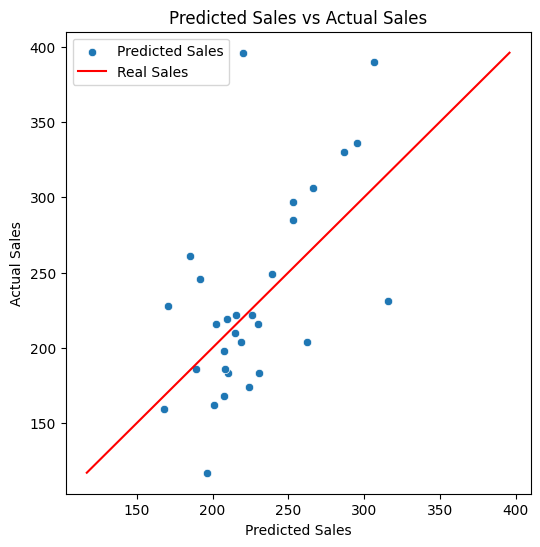

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Predicted Sales")
ax.set_ylabel("Actual Sales")

sns.scatterplot(x=y_pred_3960, y=y_test_3960, ax=ax, label="Predicted Sales")
sns.lineplot(x=y_test_3960, y=y_test_3960, color="red", ax=ax, label="Real Sales")


<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Date', ylabel='Sales'>

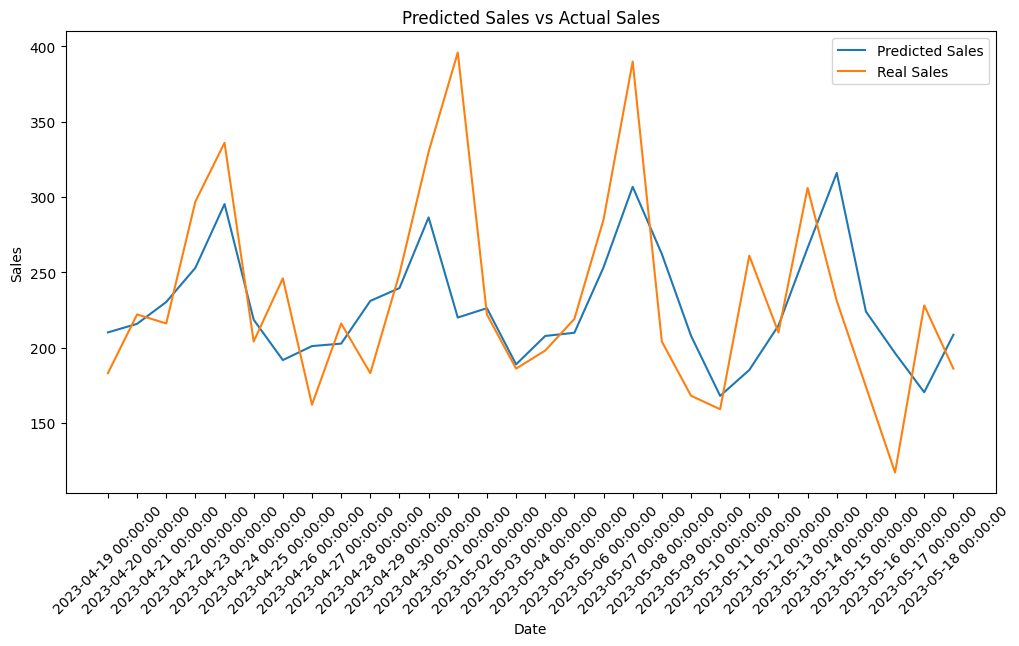

In [59]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_xticklabels(df_test_3960["fecha_venta"], rotation=45)

dates = df_test_3960["fecha_venta"].astype(str)
sns.lineplot(x=dates, y=y_pred_3960, label="Predicted Sales")
sns.lineplot(x=dates, y=y_test_3960, label="Real Sales")

#### Articulo 6523

In [60]:
import mlflow
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir el artículo específico
PRODUCT_6523 = 6523
product_family_6523 = familias_por_articulo.get(PRODUCT_6523, "Desconocida")

# Sacar los datos preparados de ese artículo
X_train_6523 = datos_preparados[PRODUCT_6523]["X_train"]
y_train_6523 = datos_preparados[PRODUCT_6523]["y_train"]
X_test_6523  = datos_preparados[PRODUCT_6523]["X_test"]
y_test_6523  = datos_preparados[PRODUCT_6523]["y_test"]

# Entrenamiento y log en MLflow
with mlflow.start_run(run_name="articulo_6523_prueba_unitaria") as run:
    mlflow.set_tag("familia", product_family_6523)
    mlflow.set_tag("product_id", PRODUCT_6523)
    mlflow.set_tag("modelo", "LinearRegression+PipelineCompleto")

    # Entrenar
    final_pipeline.fit(X_train_6523, y_train_6523)
    y_pred_6523 = final_pipeline.predict(X_test_6523)

    # Métricas
    metrics = {
        "mae_test": mean_absolute_error(y_test_6523, y_pred_6523),
        "rmse_test": np.sqrt(mean_squared_error(y_test_6523, y_pred_6523)),
        "r2_test": r2_score(y_test_6523, y_pred_6523)
    }

    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(final_pipeline, "model")

    print(f"✅ Artículo {PRODUCT_6523} ({product_family_6523}) - "
        f"MAE={metrics['mae_test']:.2f}, R²={metrics['r2_test']:.2f}")



Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/19 19:03:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Artículo 6523 (PASTELERIA) - MAE=4.97, R²=-0.21
🏃 View run articulo_6523_prueba_unitaria at: http://localhost:5000/#/experiments/523618784756416889/runs/6f252286f0c94e7a8a47bda42af05947
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889


<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Predicted Sales', ylabel='Actual Sales'>

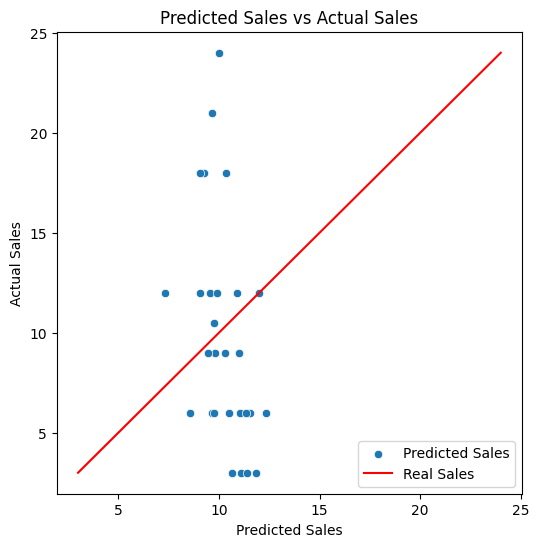

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Predicted Sales")
ax.set_ylabel("Actual Sales")

sns.scatterplot(x=y_pred_6523, y=y_test_6523, ax=ax, label="Predicted Sales")
sns.lineplot(x=y_test_6523, y=y_test_6523, color="red", ax=ax, label="Real Sales")

<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Date', ylabel='Sales'>

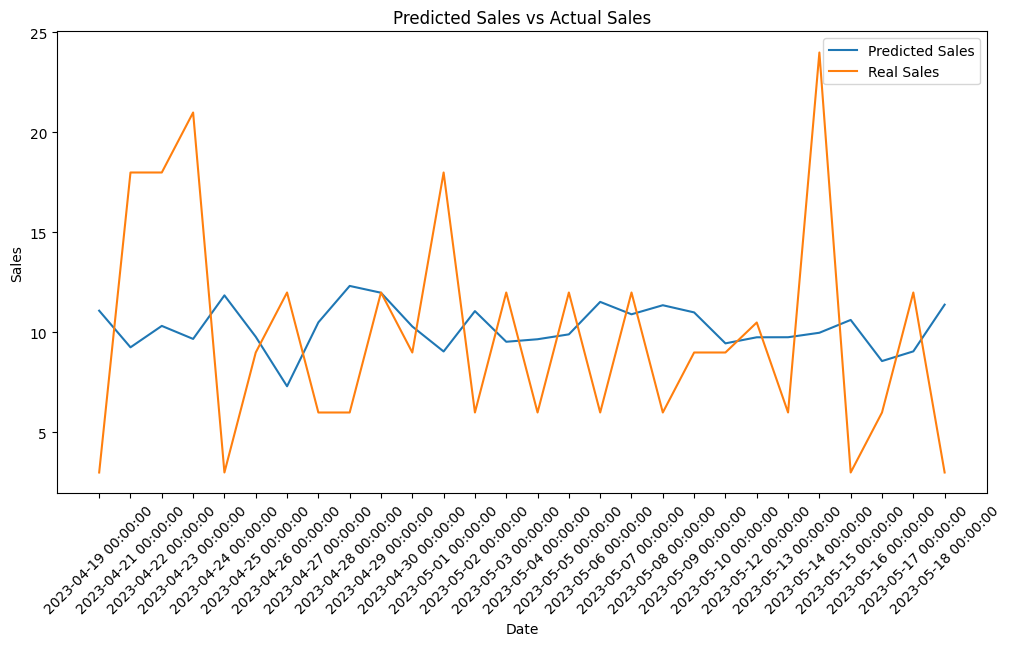

In [62]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_xticklabels(df_test_6523["fecha_venta"], rotation=45)

dates = df_test_6523["fecha_venta"].astype(str)
sns.lineplot(x=dates, y=y_pred_6523, label="Predicted Sales")
sns.lineplot(x=dates, y=y_test_6523, label="Real Sales")

#### Articulo 6451

In [63]:
import mlflow
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir el artículo específico
PRODUCT_6451 = 6451
product_family_6451 = familias_por_articulo.get(PRODUCT_6451, "Desconocida")

# Sacar los datos preparados de ese artículo
X_train_6451 = datos_preparados[PRODUCT_6451]["X_train"]
y_train_6451 = datos_preparados[PRODUCT_6451]["y_train"]
X_test_6451  = datos_preparados[PRODUCT_6451]["X_test"]
y_test_6451  = datos_preparados[PRODUCT_6451]["y_test"]

# Entrenamiento y log en MLflow
with mlflow.start_run(run_name="articulo_6451_prueba_unitaria") as run:
    mlflow.set_tag("familia", product_family_6451)
    mlflow.set_tag("product_id", PRODUCT_6451)
    mlflow.set_tag("modelo", "LinearRegression+PipelineCompleto")

    # Entrenar
    final_pipeline.fit(X_train_6451, y_train_6451)
    y_pred_6451 = final_pipeline.predict(X_test_6451)

    # Métricas
    metrics = {
        "mae_test": mean_absolute_error(y_test_6451, y_pred_6451),
        "rmse_test": np.sqrt(mean_squared_error(y_test_6451, y_pred_6451)),
        "r2_test": r2_score(y_test_6451, y_pred_6451)
    }

    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(final_pipeline, "model")

    print(f"✅ Artículo {PRODUCT_6451} ({product_family_6451}) - "
        f"MAE={metrics['mae_test']:.2f}, R²={metrics['r2_test']:.2f}")

Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/19 19:03:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Artículo 6451 (PASTELERIA) - MAE=6.19, R²=0.06
🏃 View run articulo_6451_prueba_unitaria at: http://localhost:5000/#/experiments/523618784756416889/runs/d14abf8c16a845b19cb28413c775a46c
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889


<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Predicted Sales', ylabel='Actual Sales'>

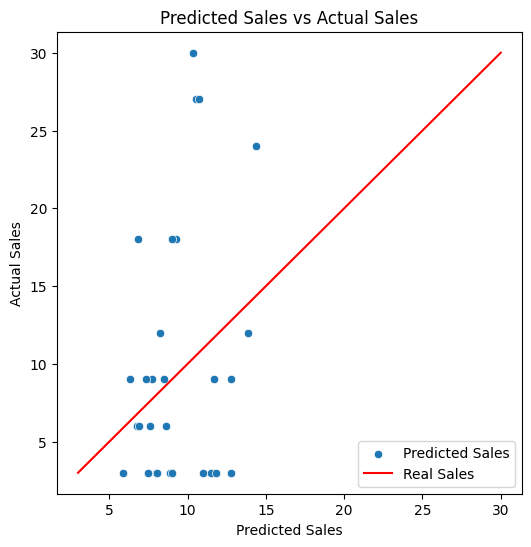

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Predicted Sales")
ax.set_ylabel("Actual Sales")

sns.scatterplot(x=y_pred_6451, y=y_test_6451, ax=ax, label="Predicted Sales")
sns.lineplot(x=y_test_6451, y=y_test_6451, color="red", ax=ax, label="Real Sales")

<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Date', ylabel='Sales'>

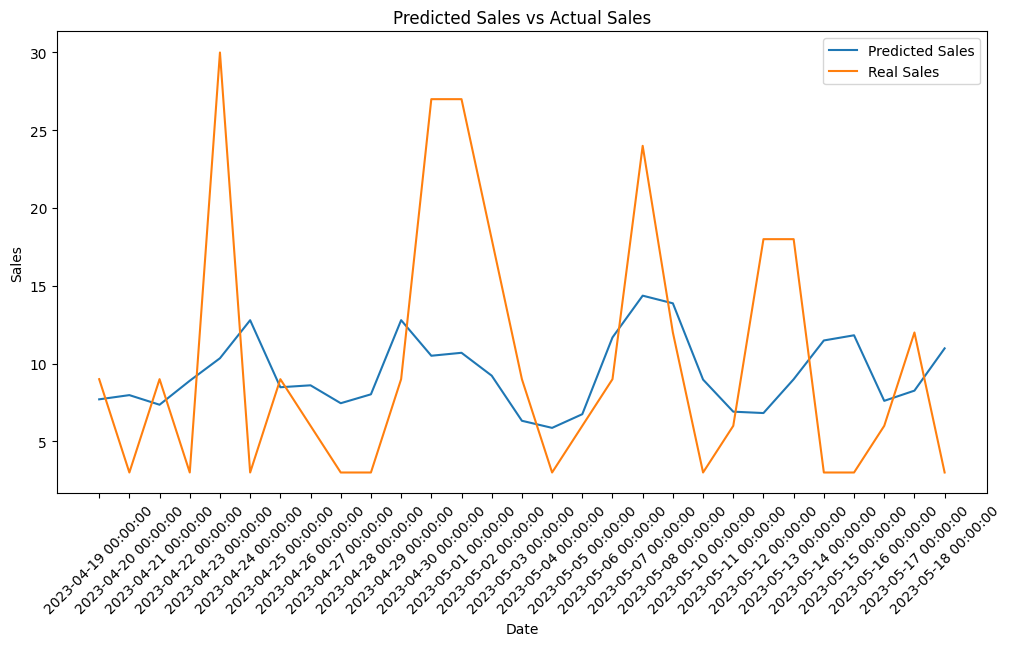

In [65]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_xticklabels(df_test_6451["fecha_venta"], rotation=45)

dates = df_test_6451["fecha_venta"].astype(str)
sns.lineplot(x=dates, y=y_pred_6451, label="Predicted Sales")
sns.lineplot(x=dates, y=y_test_6451, label="Real Sales")

#### Articulo 6549

In [66]:
import mlflow
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir el artículo específico
PRODUCT_6549 = 6549
product_family_6549 = familias_por_articulo.get(PRODUCT_6549, "Desconocida")

# Sacar los datos preparados de ese artículo
X_train_6549 = datos_preparados[PRODUCT_6549]["X_train"]
y_train_6549 = datos_preparados[PRODUCT_6549]["y_train"]
X_test_6549  = datos_preparados[PRODUCT_6549]["X_test"]
y_test_6549  = datos_preparados[PRODUCT_6549]["y_test"]

# Entrenamiento y log en MLflow
with mlflow.start_run(run_name="articulo_6549_prueba_unitaria") as run:
    mlflow.set_tag("familia", product_family_6549)
    mlflow.set_tag("product_id", PRODUCT_6549)
    mlflow.set_tag("modelo", "LinearRegression+PipelineCompleto")

    # Entrenar
    final_pipeline.fit(X_train_6549, y_train_6549)
    y_pred_6549 = final_pipeline.predict(X_test_6549)

    # Métricas
    metrics = {
        "mae_test": mean_absolute_error(y_test_6549, y_pred_6549),
        "rmse_test": np.sqrt(mean_squared_error(y_test_6549, y_pred_6549)),
        "r2_test": r2_score(y_test_6549, y_pred_6549)
    }

    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(final_pipeline, "model")

    print(f"✅ Artículo {PRODUCT_6549} ({product_family_6549}) - "
        f"MAE={metrics['mae_test']:.2f}, R²={metrics['r2_test']:.2f}")

Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/19 19:04:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Artículo 6549 (PASTELERIA) - MAE=7.31, R²=-0.08
🏃 View run articulo_6549_prueba_unitaria at: http://localhost:5000/#/experiments/523618784756416889/runs/997d2a4c4efe4a7d94a6bcfa8edc6d42
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889


<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Predicted Sales', ylabel='Actual Sales'>

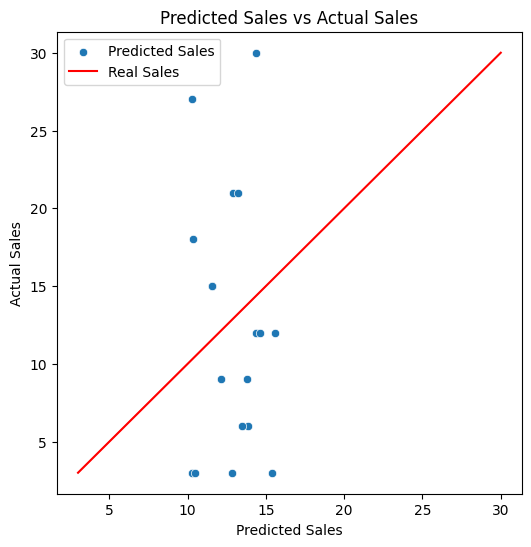

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Predicted Sales")
ax.set_ylabel("Actual Sales")

sns.scatterplot(x=y_pred_6549, y=y_test_6549, ax=ax, label="Predicted Sales")
sns.lineplot(x=y_test_6549, y=y_test_6549, color="red", ax=ax, label="Real Sales")

<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Date', ylabel='Sales'>

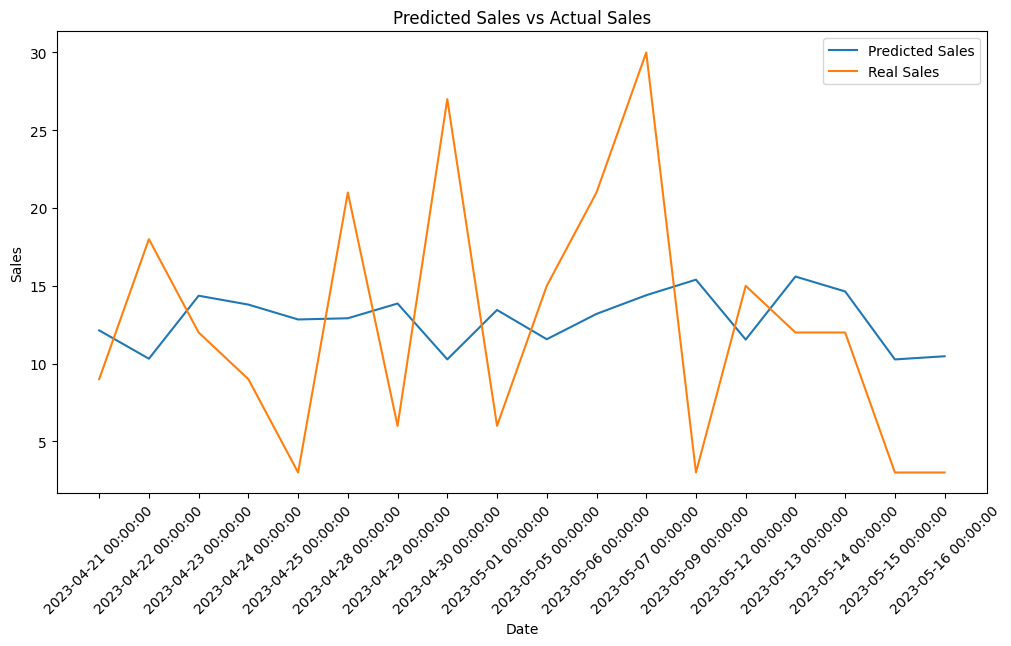

In [68]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_xticklabels(df_test_6549["fecha_venta"], rotation=45)

dates = df_test_6549["fecha_venta"].astype(str)
sns.lineplot(x=dates, y=y_pred_6549, label="Predicted Sales")
sns.lineplot(x=dates, y=y_test_6549, label="Real Sales")

#### Articulo 6425

In [69]:
import mlflow
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir el artículo específico
PRODUCT_6425 = 6425
product_family_6425 = familias_por_articulo.get(PRODUCT_6425, "Desconocida")

# Sacar los datos preparados de ese artículo
X_train_6425 = datos_preparados[PRODUCT_6425]["X_train"]
y_train_6425 = datos_preparados[PRODUCT_6425]["y_train"]
X_test_6425  = datos_preparados[PRODUCT_6425]["X_test"]
y_test_6425  = datos_preparados[PRODUCT_6425]["y_test"]

# Entrenamiento y log en MLflow
with mlflow.start_run(run_name="articulo_6425_prueba_unitaria") as run:
    mlflow.set_tag("familia", product_family_6425)
    mlflow.set_tag("product_id", PRODUCT_6425)
    mlflow.set_tag("modelo", "LinearRegression+PipelineCompleto")

    # Entrenar
    final_pipeline.fit(X_train_6425, y_train_6425)
    y_pred_6425 = final_pipeline.predict(X_test_6425)

    # Métricas
    metrics = {
        "mae_test": mean_absolute_error(y_test_6425, y_pred_6425),
        "rmse_test": np.sqrt(mean_squared_error(y_test_6425, y_pred_6425)),
        "r2_test": r2_score(y_test_6425, y_pred_6425)
    }

    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(final_pipeline, "model")

    print(f"✅ Artículo {PRODUCT_6425} ({product_family_6425}) - "
        f"MAE={metrics['mae_test']:.2f}, R²={metrics['r2_test']:.2f}")

Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/19 19:04:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Artículo 6425 (BOLLERIA) - MAE=6.64, R²=0.07
🏃 View run articulo_6425_prueba_unitaria at: http://localhost:5000/#/experiments/523618784756416889/runs/703dd0706fb94e62a96baf54ff2c722c
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889


<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Predicted Sales', ylabel='Actual Sales'>

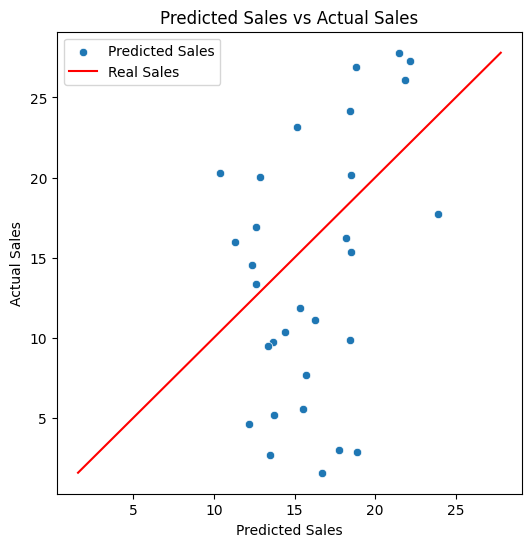

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Predicted Sales")
ax.set_ylabel("Actual Sales")

sns.scatterplot(x=y_pred_6425, y=y_test_6425, ax=ax, label="Predicted Sales")
sns.lineplot(x=y_test_6425, y=y_test_6425, color="red", ax=ax, label="Real Sales")

<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Date', ylabel='Sales'>

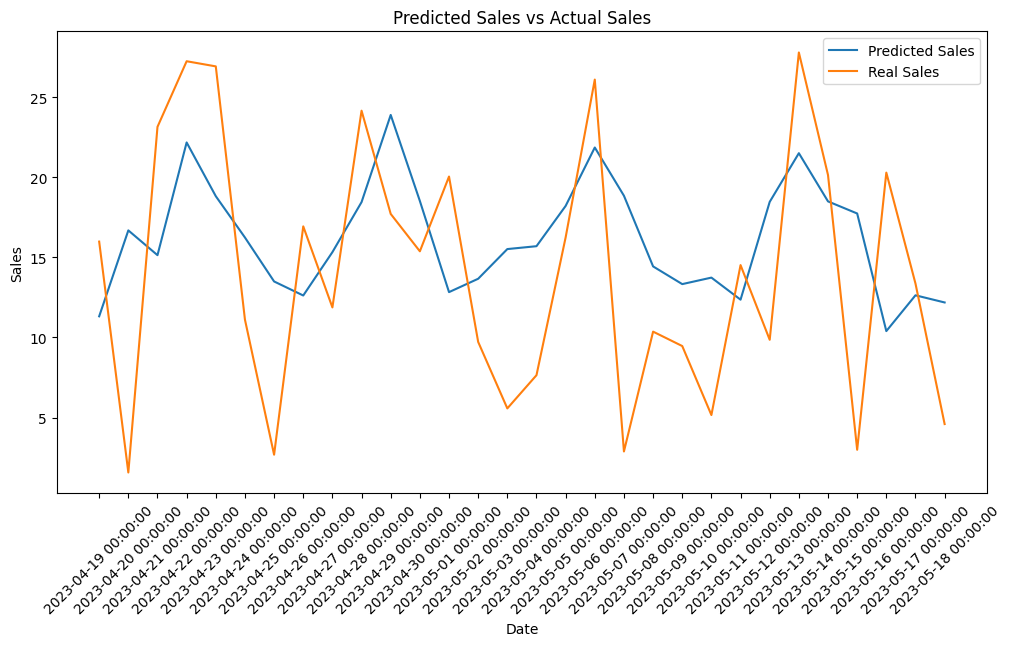

In [71]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_xticklabels(df_test_6425["fecha_venta"], rotation=45)

dates = df_test_6425["fecha_venta"].astype(str)
sns.lineplot(x=dates, y=y_pred_6425, label="Predicted Sales")
sns.lineplot(x=dates, y=y_test_6425, label="Real Sales")

#### Articulo 6286

In [72]:
import mlflow
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir el artículo específico
PRODUCT_6286 = 6286
product_family_6286 = familias_por_articulo.get(PRODUCT_6286, "Desconocida")

# Sacar los datos preparados de ese artículo
X_train_6286 = datos_preparados[PRODUCT_6286]["X_train"]
y_train_6286 = datos_preparados[PRODUCT_6286]["y_train"]
X_test_6286  = datos_preparados[PRODUCT_6286]["X_test"]
y_test_6286  = datos_preparados[PRODUCT_6286]["y_test"]

# Entrenamiento y log en MLflow
with mlflow.start_run(run_name="articulo_6286_prueba_unitaria") as run:
    mlflow.set_tag("familia", product_family_6286)
    mlflow.set_tag("product_id", PRODUCT_6286)
    mlflow.set_tag("modelo", "LinearRegression+PipelineCompleto")

    # Entrenar
    final_pipeline.fit(X_train_6286, y_train_6286)
    y_pred_6286 = final_pipeline.predict(X_test_6286)

    # Métricas
    metrics = {
        "mae_test": mean_absolute_error(y_test_6286, y_pred_6286),
        "rmse_test": np.sqrt(mean_squared_error(y_test_6286, y_pred_6286)),
        "r2_test": r2_score(y_test_6286, y_pred_6286)
    }

    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(final_pipeline, "model")

    print(f"✅ Artículo {PRODUCT_6286} ({product_family_6286}) - "
        f"MAE={metrics['mae_test']:.2f}, R²={metrics['r2_test']:.2f}")

Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/19 19:04:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Artículo 6286 (BOLLERIA) - MAE=25.17, R²=0.28
🏃 View run articulo_6286_prueba_unitaria at: http://localhost:5000/#/experiments/523618784756416889/runs/2e1e5415ade94cc697bb27fc2cec81a8
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889


<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Predicted Sales', ylabel='Actual Sales'>

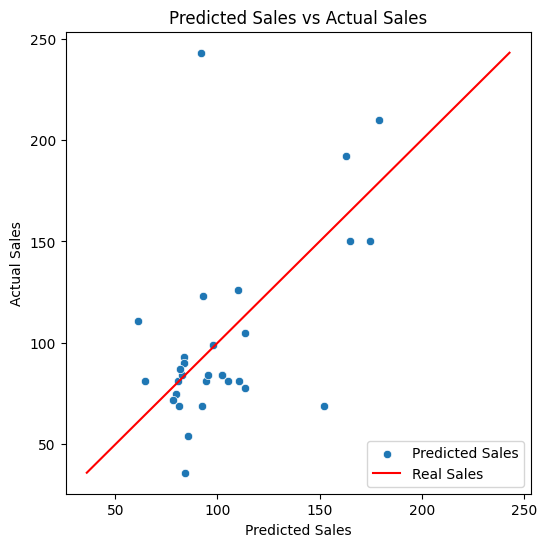

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Predicted Sales")
ax.set_ylabel("Actual Sales")

sns.scatterplot(x=y_pred_6286, y=y_test_6286, ax=ax, label="Predicted Sales")
sns.lineplot(x=y_test_6286, y=y_test_6286, color="red", ax=ax, label="Real Sales")

<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Date', ylabel='Sales'>

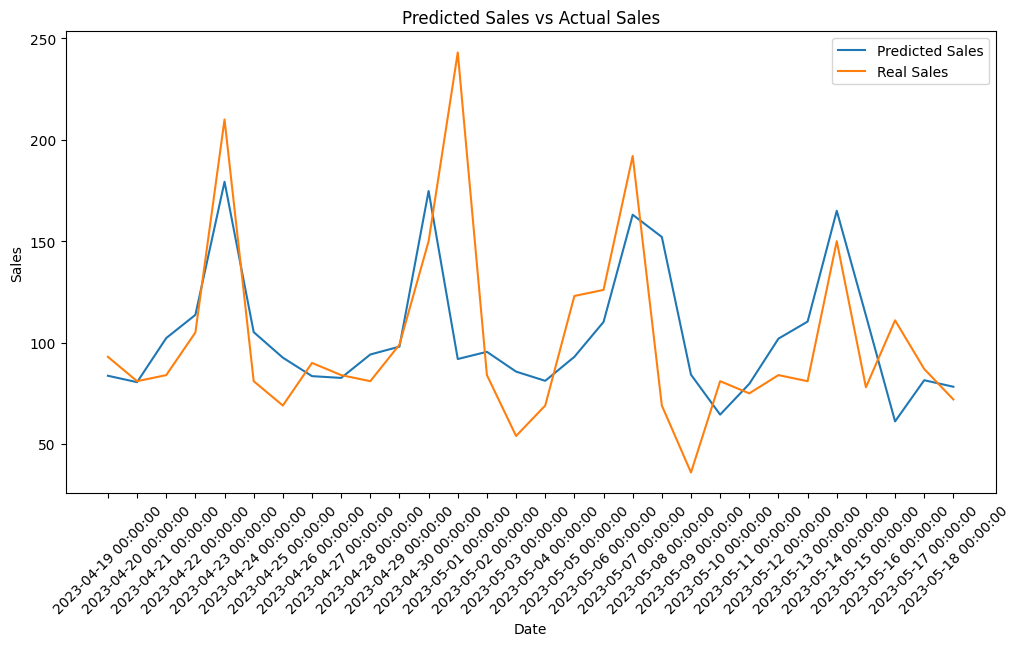

In [74]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_xticklabels(df_test_6286["fecha_venta"], rotation=45)

dates = df_test_6286["fecha_venta"].astype(str)
sns.lineplot(x=dates, y=y_pred_6286, label="Predicted Sales")
sns.lineplot(x=dates, y=y_test_6286, label="Real Sales")

#### Articulo 5803

In [75]:
import mlflow
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir el artículo específico
PRODUCT_5803 = 5803
product_family_5803 = familias_por_articulo.get(PRODUCT_5803, "Desconocida")

# Sacar los datos preparados de ese artículo
X_train_5803 = datos_preparados[PRODUCT_5803]["X_train"]
y_train_5803 = datos_preparados[PRODUCT_5803]["y_train"]
X_test_5803  = datos_preparados[PRODUCT_5803]["X_test"]
y_test_5803  = datos_preparados[PRODUCT_5803]["y_test"]

# Entrenamiento y log en MLflow
with mlflow.start_run(run_name="articulo_5803_prueba_unitaria") as run:
    mlflow.set_tag("familia", product_family_5803)
    mlflow.set_tag("product_id", PRODUCT_5803)
    mlflow.set_tag("modelo", "LinearRegression+PipelineCompleto")

    # Entrenar
    final_pipeline.fit(X_train_5803, y_train_5803)
    y_pred_5803 = final_pipeline.predict(X_test_5803)

    # Métricas
    metrics = {
        "mae_test": mean_absolute_error(y_test_5803, y_pred_5803),
        "rmse_test": np.sqrt(mean_squared_error(y_test_5803, y_pred_5803)),
        "r2_test": r2_score(y_test_5803, y_pred_5803)
    }

    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(final_pipeline, "model")

    print(f"✅ Artículo {PRODUCT_5803} ({product_family_5803}) - "
        f"MAE={metrics['mae_test']:.2f}, R²={metrics['r2_test']:.2f}")

Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/19 19:04:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Artículo 5803 (BOLLERIA) - MAE=20.80, R²=0.31
🏃 View run articulo_5803_prueba_unitaria at: http://localhost:5000/#/experiments/523618784756416889/runs/6abff8e97720438a8550b660818f9801
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889


<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Predicted Sales', ylabel='Actual Sales'>

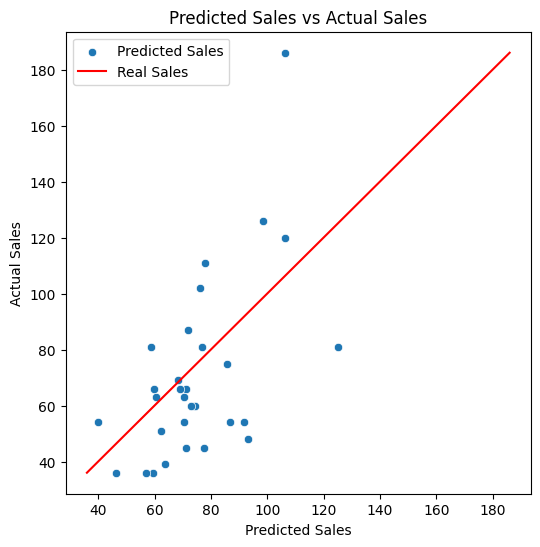

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Predicted Sales")
ax.set_ylabel("Actual Sales")

sns.scatterplot(x=y_pred_5803, y=y_test_5803, ax=ax, label="Predicted Sales")
sns.lineplot(x=y_test_5803, y=y_test_5803, color="red", ax=ax, label="Real Sales")

<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Date', ylabel='Sales'>

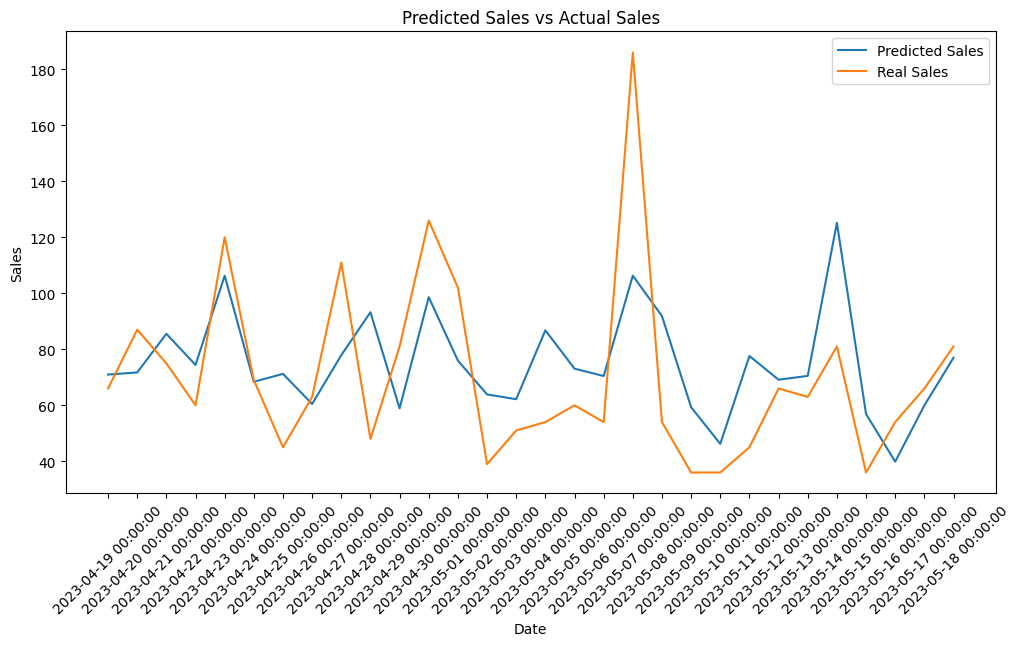

In [77]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_xticklabels(df_test_5803["fecha_venta"], rotation=45)

dates = df_test_5803["fecha_venta"].astype(str)
sns.lineplot(x=dates, y=y_pred_5803, label="Predicted Sales")
sns.lineplot(x=dates, y=y_test_5803, label="Real Sales")

#### Articulo 5404

In [78]:
import mlflow
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir el artículo específico
PRODUCT_5404 = 5404
product_family_5404 = familias_por_articulo.get(PRODUCT_5404, "Desconocida")

# Sacar los datos preparados de ese artículo
X_train_5404 = datos_preparados[PRODUCT_5404]["X_train"]
y_train_5404 = datos_preparados[PRODUCT_5404]["y_train"]
X_test_5404  = datos_preparados[PRODUCT_5404]["X_test"]
y_test_5404  = datos_preparados[PRODUCT_5404]["y_test"]

# Entrenamiento y log en MLflow
with mlflow.start_run(run_name="articulo_5404_prueba_unitaria") as run:
    mlflow.set_tag("familia", product_family_5404)
    mlflow.set_tag("product_id", PRODUCT_5404)
    mlflow.set_tag("modelo", "LinearRegression+PipelineCompleto")

    # Entrenar
    final_pipeline.fit(X_train_5404, y_train_5404)
    y_pred_5404 = final_pipeline.predict(X_test_5404)

    # Métricas
    metrics = {
        "mae_test": mean_absolute_error(y_test_5404, y_pred_5404),
        "rmse_test": np.sqrt(mean_squared_error(y_test_5404, y_pred_5404)),
        "r2_test": r2_score(y_test_5404, y_pred_5404)
    }

    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(final_pipeline, "model")

    print(f"✅ Artículo {PRODUCT_5404} ({product_family_5404}) - "
        f"MAE={metrics['mae_test']:.2f}, R²={metrics['r2_test']:.2f}")

Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/19 19:04:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Artículo 5404 (PASTELERIA) - MAE=9.71, R²=0.18
🏃 View run articulo_5404_prueba_unitaria at: http://localhost:5000/#/experiments/523618784756416889/runs/c224a095567c4334b4dfae6c6bc871d6
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889


<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Predicted Sales', ylabel='Actual Sales'>

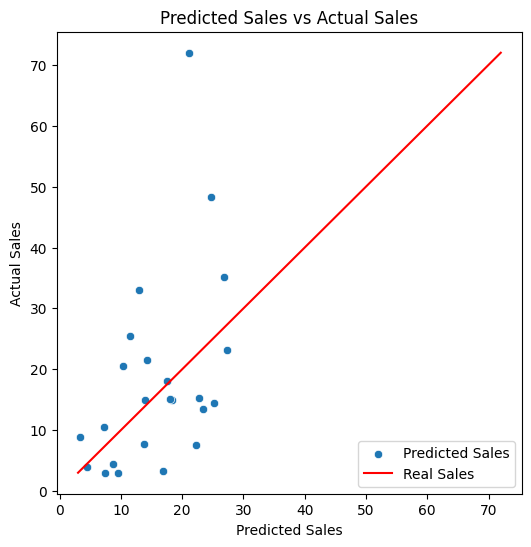

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Predicted Sales")
ax.set_ylabel("Actual Sales")

sns.scatterplot(x=y_pred_5404, y=y_test_5404, ax=ax, label="Predicted Sales")
sns.lineplot(x=y_test_5404, y=y_test_5404, color="red", ax=ax, label="Real Sales")

<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Date', ylabel='Sales'>

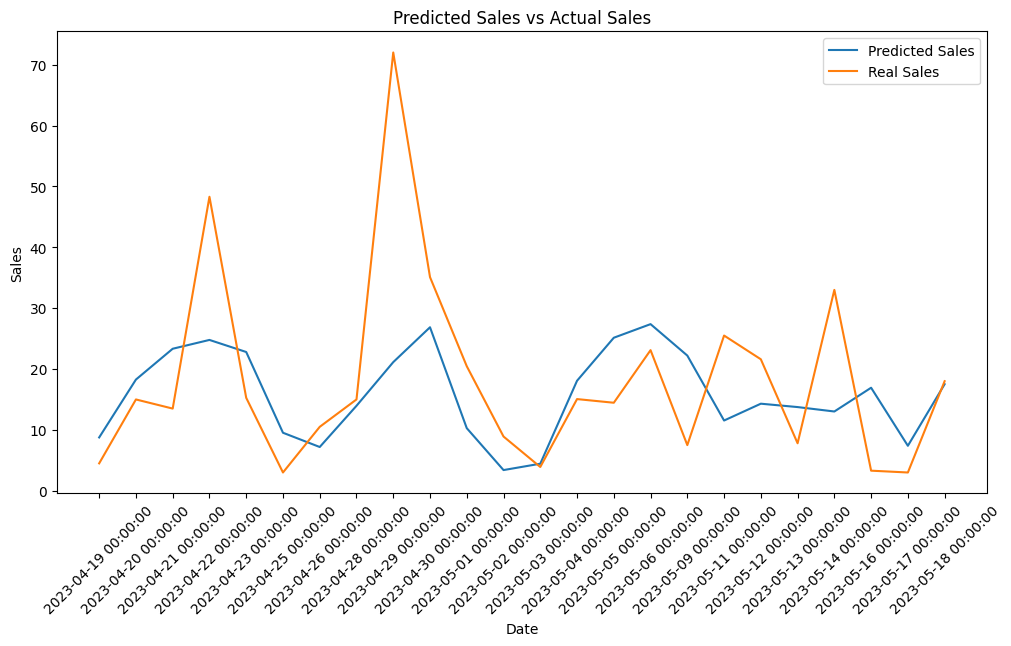

In [80]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_xticklabels(df_test_5404["fecha_venta"], rotation=45)

dates = df_test_5404["fecha_venta"].astype(str)
sns.lineplot(x=dates, y=y_pred_5404, label="Predicted Sales")
sns.lineplot(x=dates, y=y_test_5404, label="Real Sales")

#### Articulo 5403

In [81]:
import mlflow
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir el artículo específico
PRODUCT_5403 = 5403
product_family_5403 = familias_por_articulo.get(PRODUCT_5403, "Desconocida")

# Sacar los datos preparados de ese artículo
X_train_5403 = datos_preparados[PRODUCT_5403]["X_train"]
y_train_5403 = datos_preparados[PRODUCT_5403]["y_train"]
X_test_5403  = datos_preparados[PRODUCT_5403]["X_test"]
y_test_5403  = datos_preparados[PRODUCT_5403]["y_test"]

# Entrenamiento y log en MLflow
with mlflow.start_run(run_name="articulo_5403_prueba_unitaria") as run:
    mlflow.set_tag("familia", product_family_5403)
    mlflow.set_tag("product_id", PRODUCT_5403)
    mlflow.set_tag("modelo", "LinearRegression+PipelineCompleto")

    # Entrenar
    final_pipeline.fit(X_train_5403, y_train_5403)
    y_pred_5403 = final_pipeline.predict(X_test_5403)

    # Métricas
    metrics = {
        "mae_test": mean_absolute_error(y_test_5403, y_pred_5403),
        "rmse_test": np.sqrt(mean_squared_error(y_test_5403, y_pred_5403)),
        "r2_test": r2_score(y_test_5403, y_pred_5403)
    }

    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(final_pipeline, "model")

    print(f"✅ Artículo {PRODUCT_5403} ({product_family_5403}) - "
        f"MAE={metrics['mae_test']:.2f}, R²={metrics['r2_test']:.2f}")

Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/19 19:04:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Artículo 5403 (PASTELERIA) - MAE=8.58, R²=0.11
🏃 View run articulo_5403_prueba_unitaria at: http://localhost:5000/#/experiments/523618784756416889/runs/f754bc311edd4d59bb9eb966ed95ee22
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889


<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Predicted Sales', ylabel='Actual Sales'>

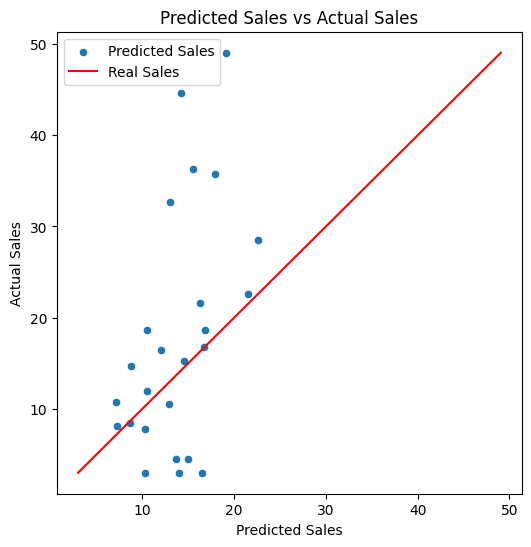

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Predicted Sales")
ax.set_ylabel("Actual Sales")

sns.scatterplot(x=y_pred_5403, y=y_test_5403, ax=ax, label="Predicted Sales")
sns.lineplot(x=y_test_5403, y=y_test_5403, color="red", ax=ax, label="Real Sales")

<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Date', ylabel='Sales'>

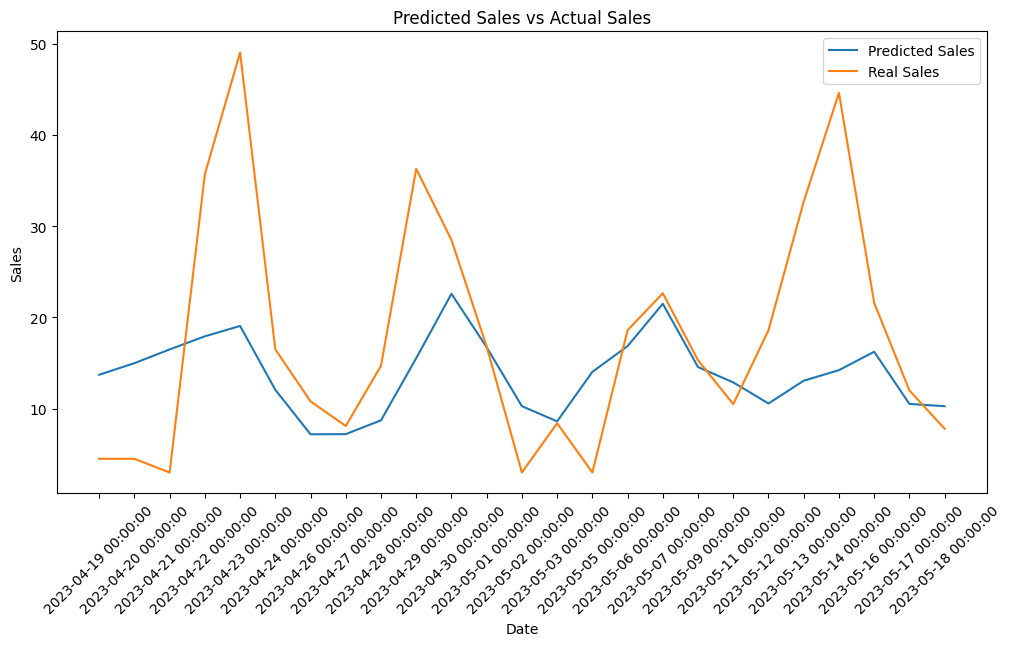

In [83]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_xticklabels(df_test_5403["fecha_venta"], rotation=45)

dates = df_test_5403["fecha_venta"].astype(str)
sns.lineplot(x=dates, y=y_pred_5403, label="Predicted Sales")
sns.lineplot(x=dates, y=y_test_5403, label="Real Sales")

#### Articulo 3880

In [84]:
import mlflow
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir el artículo específico
PRODUCT_3880 = 3880
product_family_3880 = familias_por_articulo.get(PRODUCT_3880, "Desconocida")

# Sacar los datos preparados de ese artículo
X_train_3880 = datos_preparados[PRODUCT_3880]["X_train"]
y_train_3880 = datos_preparados[PRODUCT_3880]["y_train"]
X_test_3880  = datos_preparados[PRODUCT_3880]["X_test"]
y_test_3880  = datos_preparados[PRODUCT_3880]["y_test"]

# Entrenamiento y log en MLflow
with mlflow.start_run(run_name="articulo_3880_prueba_unitaria") as run:
    mlflow.set_tag("familia", product_family_3880)
    mlflow.set_tag("product_id", PRODUCT_3880)
    mlflow.set_tag("modelo", "LinearRegression+PipelineCompleto")

    # Entrenar
    final_pipeline.fit(X_train_3880, y_train_3880)
    y_pred_3880 = final_pipeline.predict(X_test_3880)

    # Métricas
    metrics = {
        "mae_test": mean_absolute_error(y_test_3880, y_pred_3880),
        "rmse_test": np.sqrt(mean_squared_error(y_test_3880, y_pred_3880)),
        "r2_test": r2_score(y_test_3880, y_pred_3880)
    }

    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(final_pipeline, "model")

    print(f"✅ Artículo {PRODUCT_3880} ({product_family_3880}) - "
        f"MAE={metrics['mae_test']:.2f}, R²={metrics['r2_test']:.2f}")

Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/19 19:04:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Artículo 3880 (BOLLERIA) - MAE=27.70, R²=0.40
🏃 View run articulo_3880_prueba_unitaria at: http://localhost:5000/#/experiments/523618784756416889/runs/ef9bd4710ff8410698f29780d2e172fa
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889


<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Predicted Sales', ylabel='Actual Sales'>

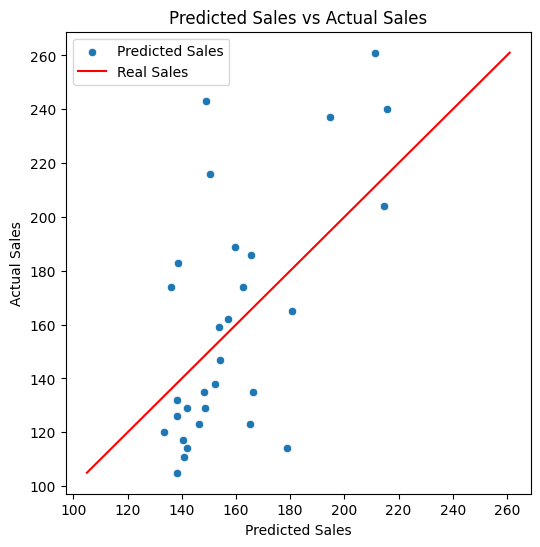

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Predicted Sales")
ax.set_ylabel("Actual Sales")

sns.scatterplot(x=y_pred_3880, y=y_test_3880, ax=ax, label="Predicted Sales")
sns.lineplot(x=y_test_3880, y=y_test_3880, color="red", ax=ax, label="Real Sales")

<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Date', ylabel='Sales'>

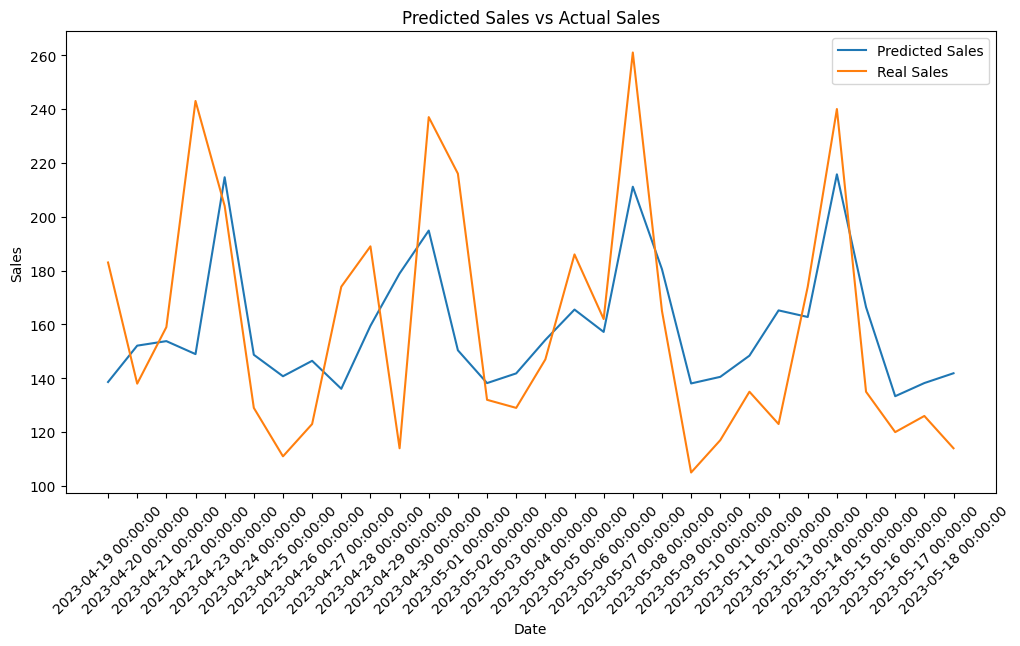

In [86]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_xticklabels(df_test_3880["fecha_venta"], rotation=45)

dates = df_test_3880["fecha_venta"].astype(str)
sns.lineplot(x=dates, y=y_pred_3880, label="Predicted Sales")
sns.lineplot(x=dates, y=y_test_3880, label="Real Sales")

#### Articulo 1084

In [87]:
import mlflow
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir el artículo específico
PRODUCT_1084 = 1084
product_family_1084 = familias_por_articulo.get(PRODUCT_1084, "Desconocida")

# Sacar los datos preparados de ese artículo
X_train_1084 = datos_preparados[PRODUCT_1084]["X_train"]
y_train_1084 = datos_preparados[PRODUCT_1084]["y_train"]
X_test_1084  = datos_preparados[PRODUCT_1084]["X_test"]
y_test_1084  = datos_preparados[PRODUCT_1084]["y_test"]

# Entrenamiento y log en MLflow
with mlflow.start_run(run_name="articulo_1084_prueba_unitaria") as run:
    mlflow.set_tag("familia", product_family_1084)
    mlflow.set_tag("product_id", PRODUCT_1084)
    mlflow.set_tag("modelo", "LinearRegression+PipelineCompleto")

    # Entrenar
    final_pipeline.fit(X_train_1084, y_train_1084)
    y_pred_1084 = final_pipeline.predict(X_test_1084)

    # Métricas
    metrics = {
        "mae_test": mean_absolute_error(y_test_1084, y_pred_1084),
        "rmse_test": np.sqrt(mean_squared_error(y_test_1084, y_pred_1084)),
        "r2_test": r2_score(y_test_1084, y_pred_1084)
    }

    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(final_pipeline, "model")

    print(f"✅ Artículo {PRODUCT_1084} ({product_family_1084}) - "
        f"MAE={metrics['mae_test']:.2f}, R²={metrics['r2_test']:.2f}")

Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/19 19:04:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Artículo 1084 (PANADERIA) - MAE=35.61, R²=-0.10
🏃 View run articulo_1084_prueba_unitaria at: http://localhost:5000/#/experiments/523618784756416889/runs/2a7121684132442aa3878428804355ea
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889


<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Predicted Sales', ylabel='Actual Sales'>

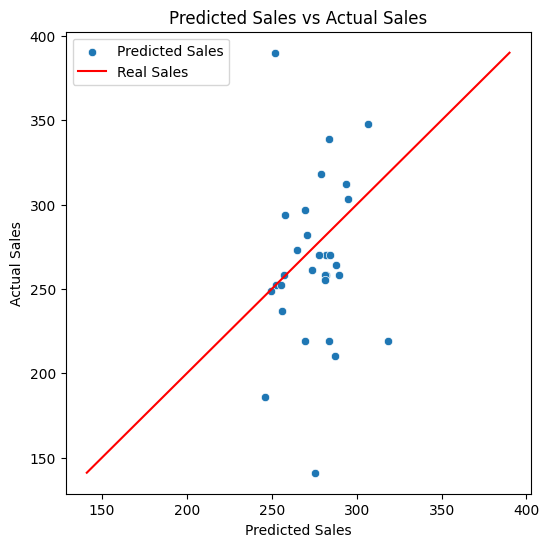

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Predicted Sales")
ax.set_ylabel("Actual Sales")

sns.scatterplot(x=y_pred_1084, y=y_test_1084, ax=ax, label="Predicted Sales")
sns.lineplot(x=y_test_1084, y=y_test_1084, color="red", ax=ax, label="Real Sales")

<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Date', ylabel='Sales'>

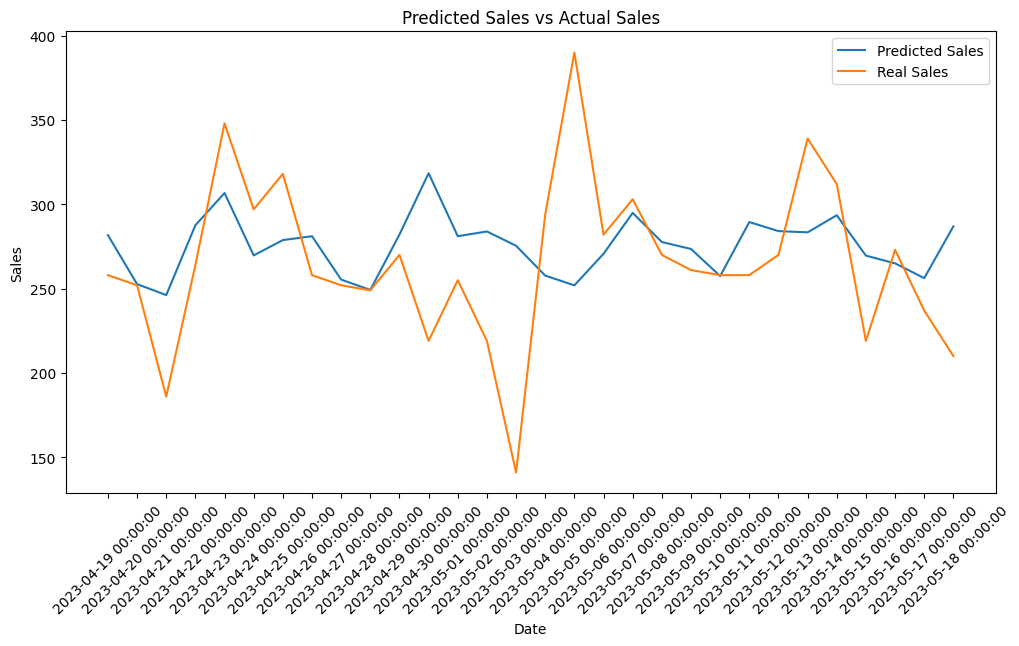

In [89]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_xticklabels(df_test_1084["fecha_venta"], rotation=45)

dates = df_test_1084["fecha_venta"].astype(str)
sns.lineplot(x=dates, y=y_pred_1084, label="Predicted Sales")
sns.lineplot(x=dates, y=y_test_1084, label="Real Sales")

#### Articulo 1043

In [90]:
import mlflow
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir el artículo específico
PRODUCT_1043 = 1043
product_family_1043 = familias_por_articulo.get(PRODUCT_1043, "Desconocida")

# Sacar los datos preparados de ese artículo
X_train_1043 = datos_preparados[PRODUCT_1043]["X_train"]
y_train_1043 = datos_preparados[PRODUCT_1043]["y_train"]
X_test_1043  = datos_preparados[PRODUCT_1043]["X_test"]
y_test_1043  = datos_preparados[PRODUCT_1043]["y_test"]

# Entrenamiento y log en MLflow
with mlflow.start_run(run_name="articulo_1043_prueba_unitaria") as run:
    mlflow.set_tag("familia", product_family_1043)
    mlflow.set_tag("product_id", PRODUCT_1043)
    mlflow.set_tag("modelo", "LinearRegression+PipelineCompleto")

    # Entrenar
    final_pipeline.fit(X_train_1043, y_train_1043)
    y_pred_1043 = final_pipeline.predict(X_test_1043)

    # Métricas
    metrics = {
        "mae_test": mean_absolute_error(y_test_1043, y_pred_1043),
        "rmse_test": np.sqrt(mean_squared_error(y_test_1043, y_pred_1043)),
        "r2_test": r2_score(y_test_1043, y_pred_1043)
    }

    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(final_pipeline, "model")

    print(f"✅ Artículo {PRODUCT_1043} ({product_family_1043}) - "
        f"MAE={metrics['mae_test']:.2f}, R²={metrics['r2_test']:.2f}")

Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/19 19:04:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Artículo 1043 (PANADERIA) - MAE=41.38, R²=0.43
🏃 View run articulo_1043_prueba_unitaria at: http://localhost:5000/#/experiments/523618784756416889/runs/02d1f206e76c443dbe89507fd404d2c2
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889


<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Predicted Sales', ylabel='Actual Sales'>

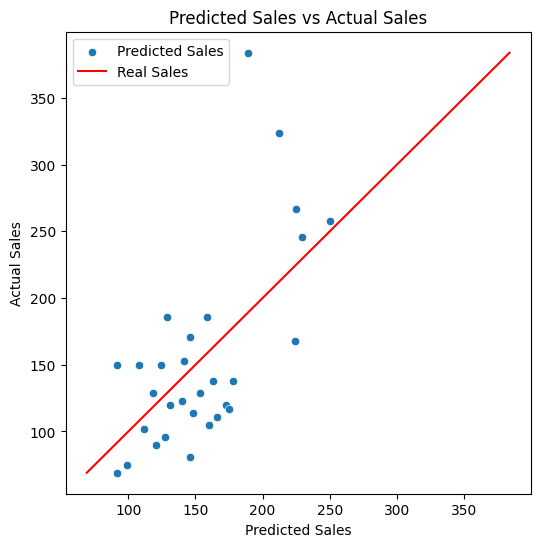

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Predicted Sales")
ax.set_ylabel("Actual Sales")

sns.scatterplot(x=y_pred_1043, y=y_test_1043, ax=ax, label="Predicted Sales")
sns.lineplot(x=y_test_1043, y=y_test_1043, color="red", ax=ax, label="Real Sales")

<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Date', ylabel='Sales'>

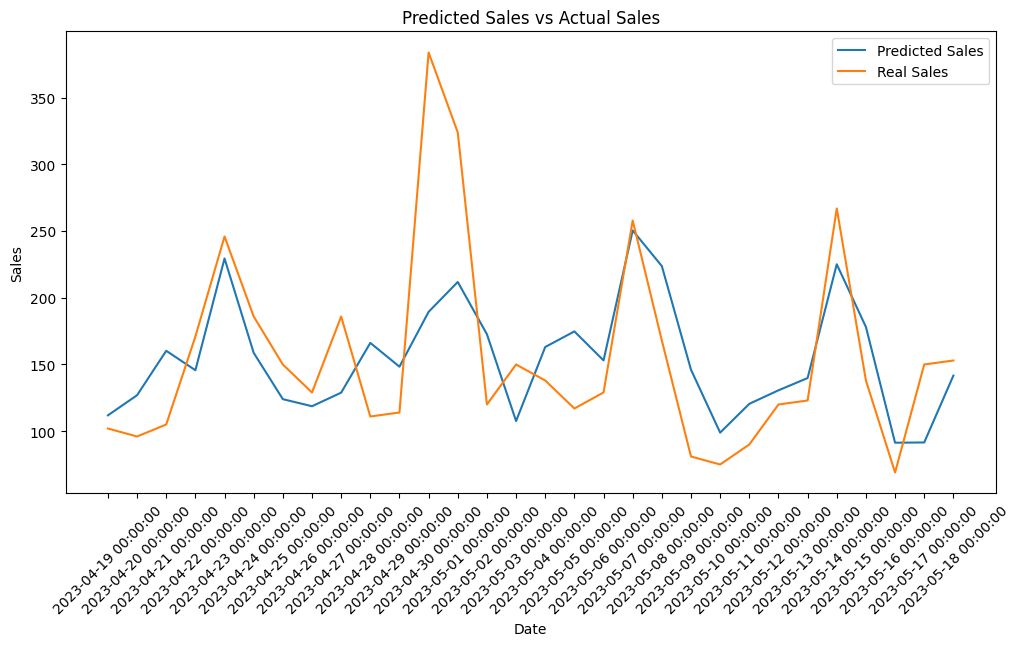

In [92]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_xticklabels(df_test_1043["fecha_venta"], rotation=45)

dates = df_test_1043["fecha_venta"].astype(str)
sns.lineplot(x=dates, y=y_pred_1043, label="Predicted Sales")
sns.lineplot(x=dates, y=y_test_1043, label="Real Sales")

#### Articulo 968

In [93]:
import mlflow
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir el artículo específico
PRODUCT_968 = 968
product_family_968 = familias_por_articulo.get(PRODUCT_968, "Desconocida")

# Sacar los datos preparados de ese artículo
X_train_968 = datos_preparados[PRODUCT_968]["X_train"]
y_train_968 = datos_preparados[PRODUCT_968]["y_train"]
X_test_968  = datos_preparados[PRODUCT_968]["X_test"]
y_test_968  = datos_preparados[PRODUCT_968]["y_test"]

# Entrenamiento y log en MLflow
with mlflow.start_run(run_name="articulo_968_prueba_unitaria") as run:
    mlflow.set_tag("familia", product_family_968)
    mlflow.set_tag("product_id", PRODUCT_968)
    mlflow.set_tag("modelo", "LinearRegression+PipelineCompleto")

    # Entrenar
    final_pipeline.fit(X_train_968, y_train_968)
    y_pred_968 = final_pipeline.predict(X_test_968)

    # Métricas
    metrics = {
        "mae_test": mean_absolute_error(y_test_968, y_pred_968),
        "rmse_test": np.sqrt(mean_squared_error(y_test_968, y_pred_968)),
        "r2_test": r2_score(y_test_968, y_pred_968)
    }

    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(final_pipeline, "model")

    print(f"✅ Artículo {PRODUCT_968} ({product_family_968}) - "
        f"MAE={metrics['mae_test']:.2f}, R²={metrics['r2_test']:.2f}")

Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/19 19:04:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Artículo 968 (PANADERIA) - MAE=39.99, R²=0.24
🏃 View run articulo_968_prueba_unitaria at: http://localhost:5000/#/experiments/523618784756416889/runs/9c2b40a54a774e0c97ec00b57196ff2b
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889


<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Predicted Sales', ylabel='Actual Sales'>

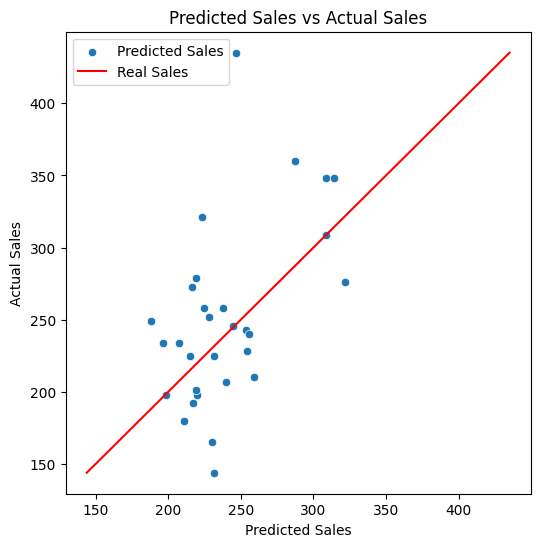

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Predicted Sales")
ax.set_ylabel("Actual Sales")

sns.scatterplot(x=y_pred_968, y=y_test_968, ax=ax, label="Predicted Sales")
sns.lineplot(x=y_test_968, y=y_test_968, color="red", ax=ax, label="Real Sales")

<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Date', ylabel='Sales'>

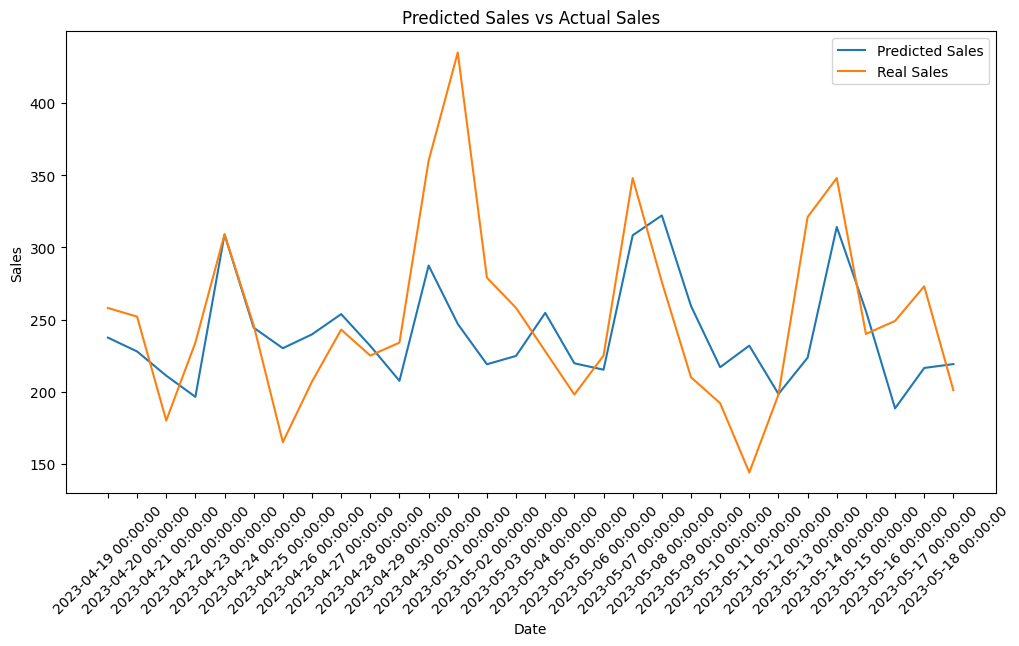

In [95]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_xticklabels(df_test_968["fecha_venta"], rotation=45)

dates = df_test_968["fecha_venta"].astype(str)
sns.lineplot(x=dates, y=y_pred_968, label="Predicted Sales")
sns.lineplot(x=dates, y=y_test_968, label="Real Sales")

#### Articulo 900

In [96]:
import mlflow
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir el artículo específico
PRODUCT_900 = 900
product_family_900 = familias_por_articulo.get(PRODUCT_900, "Desconocida")

# Sacar los datos preparados de ese artículo
X_train_900 = datos_preparados[PRODUCT_900]["X_train"]
y_train_900 = datos_preparados[PRODUCT_900]["y_train"]
X_test_900  = datos_preparados[PRODUCT_900]["X_test"]
y_test_900  = datos_preparados[PRODUCT_900]["y_test"]

# Entrenamiento y log en MLflow
with mlflow.start_run(run_name="articulo_900_prueba_unitaria") as run:
    mlflow.set_tag("familia", product_family_900)
    mlflow.set_tag("product_id", PRODUCT_900)
    mlflow.set_tag("modelo", "LinearRegression+PipelineCompleto")

    # Entrenar
    final_pipeline.fit(X_train_900, y_train_900)
    y_pred_900 = final_pipeline.predict(X_test_900)

    # Métricas
    metrics = {
        "mae_test": mean_absolute_error(y_test_900, y_pred_900),
        "rmse_test": np.sqrt(mean_squared_error(y_test_900, y_pred_900)),
        "r2_test": r2_score(y_test_900, y_pred_900)
    }

    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(final_pipeline, "model")

    print(f"✅ Artículo {PRODUCT_900} ({product_family_900}) - "
        f"MAE={metrics['mae_test']:.2f}, R²={metrics['r2_test']:.2f}")

Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/19 19:04:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Artículo 900 (PANADERIA) - MAE=80.41, R²=0.06
🏃 View run articulo_900_prueba_unitaria at: http://localhost:5000/#/experiments/523618784756416889/runs/563430c7467d45e0a6f7896b5e9db077
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889


<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Predicted Sales', ylabel='Actual Sales'>

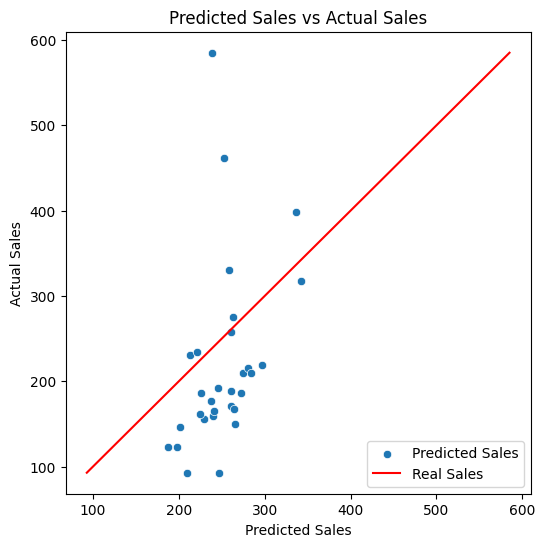

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Predicted Sales")
ax.set_ylabel("Actual Sales")

sns.scatterplot(x=y_pred_900, y=y_test_900, ax=ax, label="Predicted Sales")
sns.lineplot(x=y_test_900, y=y_test_900, color="red", ax=ax, label="Real Sales")

<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Date', ylabel='Sales'>

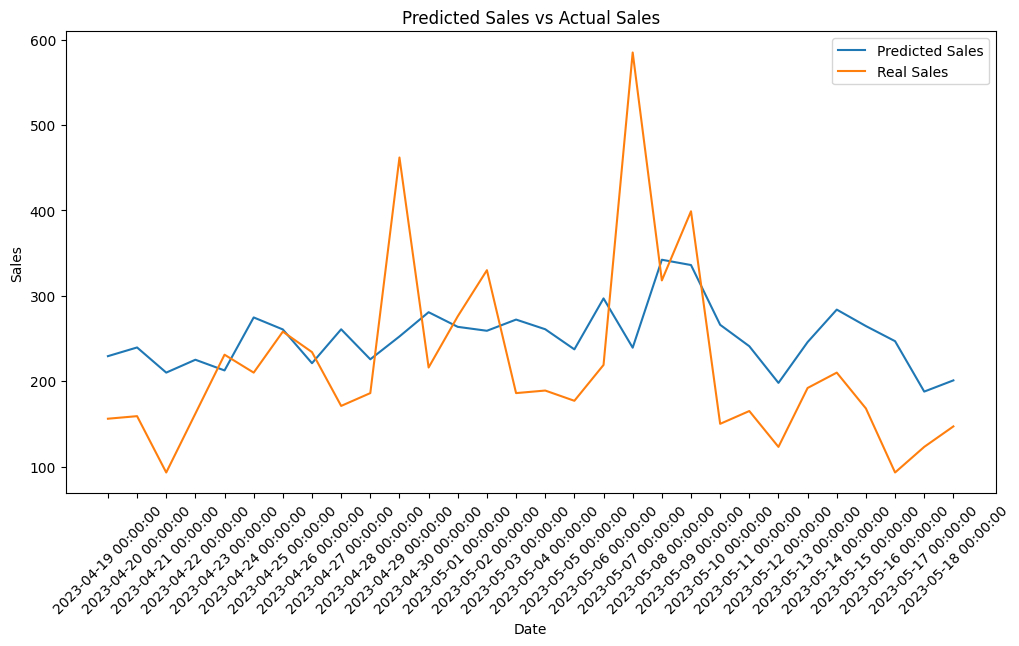

In [98]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_xticklabels(df_test_900["fecha_venta"], rotation=45)

dates = df_test_900["fecha_venta"].astype(str)
sns.lineplot(x=dates, y=y_pred_900, label="Predicted Sales")
sns.lineplot(x=dates, y=y_test_900, label="Real Sales")

#### Articulo 417

In [99]:
import mlflow
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir el artículo específico
PRODUCT_417 = 417
product_family_417 = familias_por_articulo.get(PRODUCT_417, "Desconocida")

# Sacar los datos preparados de ese artículo
X_train_417 = datos_preparados[PRODUCT_417]["X_train"]
y_train_417 = datos_preparados[PRODUCT_417]["y_train"]
X_test_417  = datos_preparados[PRODUCT_417]["X_test"]
y_test_417  = datos_preparados[PRODUCT_417]["y_test"]

# Entrenamiento y log en MLflow
with mlflow.start_run(run_name="articulo_417_prueba_unitaria") as run:
    mlflow.set_tag("familia", product_family_417)
    mlflow.set_tag("product_id", PRODUCT_417)
    mlflow.set_tag("modelo", "LinearRegression+PipelineCompleto")

    # Entrenar
    final_pipeline.fit(X_train_417, y_train_417)
    y_pred_417 = final_pipeline.predict(X_test_417)

    # Métricas
    metrics = {
        "mae_test": mean_absolute_error(y_test_417, y_pred_417),
        "rmse_test": np.sqrt(mean_squared_error(y_test_417, y_pred_417)),
        "r2_test": r2_score(y_test_417, y_pred_417)
    }

    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(final_pipeline, "model")

    print(f"✅ Artículo {PRODUCT_417} ({product_family_417}) - "
        f"MAE={metrics['mae_test']:.2f}, R²={metrics['r2_test']:.2f}")

Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcarán festivos.


2025/09/19 19:04:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Artículo 417 (PANADERIA) - MAE=6.83, R²=-0.02
🏃 View run articulo_417_prueba_unitaria at: http://localhost:5000/#/experiments/523618784756416889/runs/4e632174969f4c0a8dd89ab203868ad0
🧪 View experiment at: http://localhost:5000/#/experiments/523618784756416889


<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Predicted Sales', ylabel='Actual Sales'>

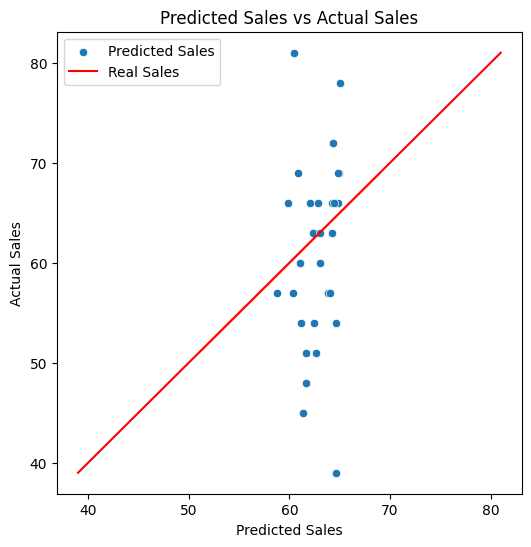

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Predicted Sales")
ax.set_ylabel("Actual Sales")

sns.scatterplot(x=y_pred_417, y=y_test_417, ax=ax, label="Predicted Sales")
sns.lineplot(x=y_test_417, y=y_test_417, color="red", ax=ax, label="Real Sales")

<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Date', ylabel='Sales'>

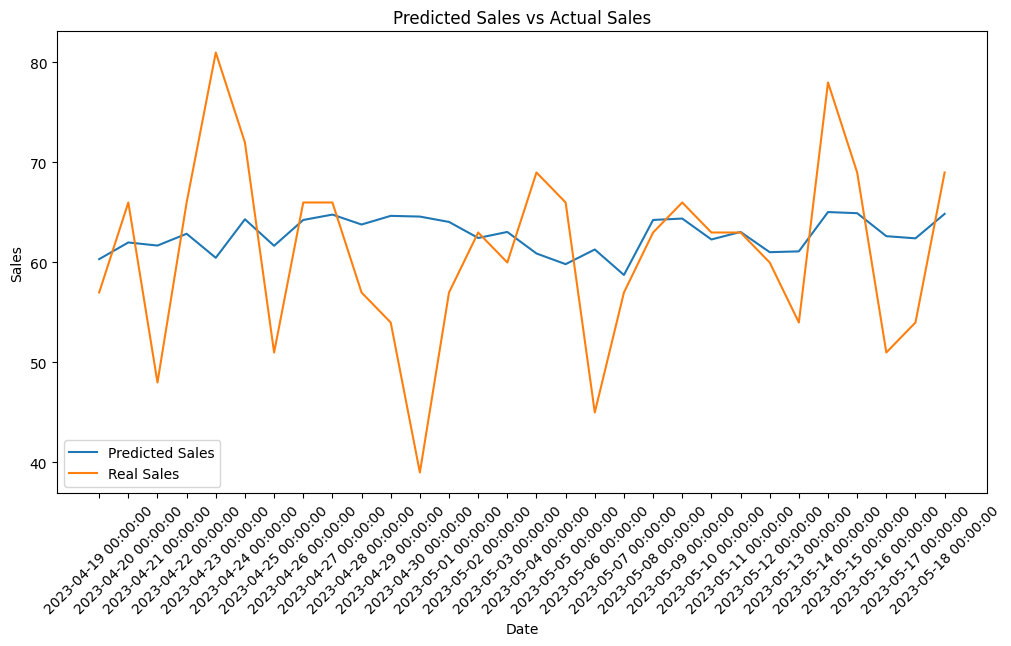

In [101]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_xticklabels(df_test_417["fecha_venta"], rotation=45)

dates = df_test_417["fecha_venta"].astype(str)
sns.lineplot(x=dates, y=y_pred_417, label="Predicted Sales")
sns.lineplot(x=dates, y=y_test_417, label="Real Sales")

#### Conclusiones

Este modelo tiene mejores resultados cuando se entrena por artículo, aunque algunos artículos se deberá de hacer un nuevo modelo para poder mejorar las predicciones.

### 5. Productivización del modelo

👇 Se ha desplegado el modelo y registrado en MLFLOW

```bash
(venv) PS D:\Proyecto> mlflow server
INFO:waitress:Serving on http://127.0.0.1:5000
```

### 6. Subir los resultados a la base de datos

In [102]:
# Creando listas para subir las predicciones

productos = [6549, 6523, 6451, 6425, 6286, 5803, 5404, 5403, 3960, 3880, 1084, 1043, 968, 900, 417]

df_tests = {
    6549: df_test_6549,
    6523: df_test_6523,
    6451: df_test_6451,
    6425: df_test_6425,
    6286: df_test_6286,
    5803: df_test_5803,
    5404: df_test_5404,
    5403: df_test_5403,
    3960: df_test_3960,
    3880: df_test_3880,
    1084: df_test_1084,
    1043: df_test_1043,
    968: df_test_968,
    900: df_test_900,
    417: df_test_417
}

familias = {
    6549: product_family_6549,
    6523: product_family_6523,
    6451: product_family_6451,
    6425: product_family_6425,
    6286: product_family_6286,
    5803: product_family_5803,
    5404: product_family_5404,
    5403: product_family_5403,
    3960: product_family_3960,
    3880: product_family_3880,
    1084: product_family_1084,
    1043: product_family_1043,
    968: product_family_968,
    900: product_family_900,
    417: product_family_417
}

predictions = {
    6549: y_pred_6549,
    6523: y_pred_6523,
    6451: y_pred_6451,
    6425: y_pred_6425,
    6286: y_pred_6286,
    5803: y_pred_5803,
    5404: y_pred_5404,
    5403: y_pred_5403,
    3960: y_pred_3960,
    3880: y_pred_3880,
    1084: y_pred_1084,
    1043: y_pred_1043,
    968: y_pred_968,
    900: y_pred_900,
    417: y_pred_417
}

In [103]:
df_predicciones = pd.DataFrame()

for prod_id in productos:
    df_temp = pd.DataFrame({
        "fecha": df_tests[prod_id]["fecha_venta"].tolist(),
        "cantidad": predictions[prod_id],
        "articulo": [prod_id] * len(predictions[prod_id]),
        "familia": [familias[prod_id]] * len(predictions[prod_id])
    })
    
    df_predicciones = pd.concat([df_predicciones, df_temp], ignore_index=True)

df_predicciones.head()

fecha   cantidad  articulo     familia
0 2023-04-21  12.137557      6549  PASTELERIA
1 2023-04-22  10.314500      6549  PASTELERIA
2 2023-04-23  14.364103      6549  PASTELERIA
3 2023-04-24  13.793899      6549  PASTELERIA
4 2023-04-25  12.837346      6549  PASTELERIA

In [104]:
df_predicciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   fecha     424 non-null    datetime64[ns]
 1   cantidad  424 non-null    float64       
 2   articulo  424 non-null    int64         
 3   familia   424 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 13.4+ KB


Subiendo a la base de datos

In [105]:
DATABASE = "sandbox"
NAME = "JeanPaul"  # ‼️ Cambia esta variable por tu nombre. 

table_name = f"Materials_Prediction_Group_{NAME}"

# Connect to the database
db = DatabaseConnection(DB_USERNAME, DB_PASSWORD, database=DATABASE)
db.insert_dataframe(df_predicciones, table_name)